# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science

## Homework 7: Artificial Neural Networks, Model Interpretation, and Regularization


**Harvard University**<br/>
**Fall 2020**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader and Chris Tanner

<hr style="height:2pt">

In [111]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css"
).text
HTML(styles)

In [112]:
import random
random.seed(112358)

import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import callbacks

%matplotlib inline

<hr style="height:2pt">

### INSTRUCTIONS

- **THIS IS AN INDIVIDUAL ASSIGNMENT.**

- **DO NOT PROCRASTINATE! Expect your completed code in this notebook to take 20-60 minutes to run depending on your computer hardware.**

- To submit your assignment follow the instructions given in Canvas.

- This assignment **must be done individually.**

- Please restart the kernel and run the entire notebook again before you submit.

- Running cells out of order is a common pitfall in Jupyter Notebooks. To make sure your code works restart the kernel and run the whole notebook again before you submit. Exceptions should be made for code with an extremely long execution time, of course.
- We have tried to include all the libraries you may need to do the assignment in the imports statement at the top of this notebook. We strongly suggest that you use those and not others as we may not be familiar with them.
- Please use .head() when viewing data. Do not submit a notebook that is **excessively long**. 
- In questions that require code to answer, such as "calculate the $R^2$", do not just output the value from a cell. Write a `print()` function that includes a reference to the calculated value, **not hardcoded**. For example:
```python
print(f'The R^2 is {R:.4f}')
```
- Your plots should be clearly labeled, including clear labels for the $x$ and $y$ axes as well as a descriptive title ("MSE plot" is not a descriptive title; "95% confidence interval of coefficients of polynomial degree 5" is).

<hr style="height:2pt">

<a id="contents"></a>

# Notebook Contents

- [**PART 1 [65 pts]: Model interpretation and predictive intervals in ANNs**](#part1)
  - [Overview and Data Description](#part1intro)
  - [Questions](#part1questions)
  - [Solutions](#part1solutions)


- [**PART 2 [35 pts]: Kannada MNIST Kaggle competition**](#part2)
  - [Problem Statement](#part2intro)
  - [The Kannada MNIST Dataset](#part2about)
  - [Downloading the Data Files](#part2data)
  - [CS109A Kaggle Competition](#part2kaggle)
  - [Questions](#part2questions)
  - [Solutions](#part2solutions)


<a id="part1"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

# PART 1 [65 pts]: Model interpretation and predictive intervals in ANNs

[Return to contents](#contents)

<a id="part1intro"></a>

## Overview and Data Description

[Return to contents](#contents)

In this problem, you will be building and interpreting models to predict whether a flight was delayed for its arrival. The model will be based on features that can be measured as the flight takes off.

We will also estimate the predictive intervals of the model using bootstrapping. We will utilize those predictive intervals to build a new kind of model: a model that refrains from making a prediction when it is not confident.

The included variables are:

    
**ARRIVAL_DELAY**: the difference between scheduled arrival and actual arrival, in minutes (positive is late, negative is early).

**DISTANCE**: the distance between arrival and departure airports, in miles.

**SCHEDULED_TIME**: the flight's scheduled travel time.

**MONTH**: the month the flight took off, 1 = January, 2 = February, etc.

**SCHED_DEP_HOUR**: the scheduled departure time (the hour of the day).

**SCHED_ARR_HOUR**: the scheduled arrival time (the hour of the day).

**FLIGHT_COUNT**: the number of flights flying out of the origin airport before noon on a typical day.

**DAY_OF_WEEK**: the day of the week, 1 = Monday, 2 = Tuesday, etc.

**ORIGIN_AIRPORT**: the airport the flight took off from.

**DESTINATION_AIRPORT**: the airport the flight was scheduled to land at.

For the airport codes, see: https://www.bts.gov/topics/airlines-and-airports/world-airport-codes

To sucessfully complete this part, you will proceed by fitting a NN model, evaluating its accuracy, interpreting the predictors' importance, and finally evaluating the predictive intervals.

**NOTE:** the observations were sampled so that roughly half of the observations were delayed and half of the observations were not delayed.

<!-- </div> -->

<a id="part1questions"></a>

## <div class='exercise'>PART 1: Questions</div> 

[Return to contents](#contents)

<a id="q11"></a>

**[1.1:](#s11) Preprocess the data**

Our first step will be to read in our dataset and preprocess our data.

- **[1.1.1:](#s11)**  Read in the dataset `flights.csv`. Create a variable `DELAY_OR_NOT` that denotes whether `ARRIVAL_DELAY` is greater-than-or-equal-to 15 minutes (the FAA and BTS define a flight as delayed only if it arrives 15 minutes late or more). This is going to be the response variable for the rest of this question. 


- **[1.1.2:](#s112)** Preprocess the data: deal with missing values if there are any, one-hot-encode the non-numeric categorical variables, and split and scale the data (use an 80/20 train-test split with `random_state=111`). Print the resulting shapes of your $X$ and $y$ dataframes for both your train and your test sets. **NOTE:** While inspecting your data, you may notice that a large number of airport codes are recorded using 5-digit values instead of the expected 3-letter codes. That is perfectly fine. Those 5-digit values should be considered valid and just be treated the same as they would be if they were 3-letter codes.

<a id="q12"></a>

**[1.2:](#s12) Fit an ANN**

Fit an artificial neural network model using all predictors (name this model `NN_model`).  Use a dense feed-forward network with two hidden layers with 15 nodes in each hidden layer. For this network, use a reasonable activation function for the hidden layers, select an appropriate loss function and optimizer, specify a validation split of 0.2, train for a reasonable number of epochs (you can base this number on the results of your training and validation accuracy plot), and feel free to use tensorflow's default batch size while training. Plot the training accuracy and validation accuracy as a function of epochs from your `NN_model` training history. Evaluate the `NN_model` model on both train and test, and print out the resulting train and test accuracies.

<a id="q13"></a>

**[1.3:](#s13) Fit and examine a "proxy" model**

To begin our interpretation of the resulting `NN_model`, we will first use a "proxy model" that we know how to interpret and train it on our `NN_model` class predictions rather than the true $y$ training values.


- **[1.3.1:](#s13)** First, generate a set of `NN_model` class predictions for the training set. These $\hat{y}$ training predictions will be used instead of the true $y$ training values when we fit our proxy model in 1.3.2. The $X$ values used in our 1.3.2 proxy model should be the same ones used for `NN_model`.


- **[1.3.2:](#s132)** Next, fit a logistic regression model using your $\hat{y}$ values from 1.3.1 (name this model `logreg`). Use ridge-like regularization. Print the `logreg` test accuracy to confirm that it is similar to what we saw for our `NN_model` test accuracy in 1.2. You may need to adjust `C` in order to achieve a similar accuracy.


- **[1.3.3:](#s133)** Now use sklearn's `permutation_importance` function (already included in this notebook's imports) to compute the feature importance using the `logreg` model. Plot the **relative** feature importance for the top-10 most important predictors identified by the `permutation_importance` function.

  - Please refer to sklearn's official documentation to learn how this function works.
  
  - When running `permutation_importance` for this problem, you can use the default number of `n_repeats` and your estimator's default `scorer`. To speed up the time it takes to run your permutations, you can try setting `n_jobs=-1` to take full advantage of all of your available processor cores.

<a id="q14"></a>

**[1.4:](#s14) Visualize important features**

Another way to interpret the  `NN_model` is by examining the response as a function of any of the predictors. Particularly, we will select from features often found most significant from the analysis above. **For all 1.4 plots below**, for ease of interpretation, **please be certain to** display all predictors on their original scales. **NOTE:** The predictors you are required to use in 1.4 may differ from some of the top-10 predictors you identified in 1.3 as a result of random variability in our algorithms.


   - **[1.4.1:](#s14)** Set all predictors to their means/modes except for `SCHED_DEP_HOUR`. Predict the `NN_model` probability of delay and plot the predicted probabilities of delay vs. `SCHED_DEP_HOUR` on the data from the **training set**. Interpret what you see in 2-4 sentences.

 
   - **[1.4.2:](#s142)** Set all predictors to their means/modes except for `SCHED_DEP_HOUR` and `FLIGHT_COUNT`. Predict the `NN_model` probability of delay and plot the predicted probabilities of delay vs. `SCHED_DEP_HOUR` and `FLIGHT_COUNT` from the training set (see the question 1.4 "HINT" below).


   - **[1.4.3:](#s143)** Set all predictors to their means/modes except for except for `SCHED_DEP_HOUR` and `SCHED_ARR_HOUR`. Predict the `NN_model` probability of delay and plot the predicted probabilities of delay vs. `SCHED_DEP_HOUR` and `SCHED_ARR_HOUR` from the training set.


   - **[1.4.4:](#s144)** Set all predictors to their means/modes except for except for `SCHED_DEP_HOUR` and `DISTANCE`. Predict the `NN_model` probability of delay and plot the predicted probabilities of delay vs. `SCHED_DEP_HOUR` and `DISTANCE` from the training set. 


  - **[1.4.5:](#s145)** In 5-10 sentences, interpret what you have seen in 1.4.2, 1.4.3, and 1.4.4.

**HINT:** For 1.4.2, 1.4.3, and 1.4.4, when you include `SCHED_DEP_HOUR` on one axis and your second predictor on the other axis, you can color your data points based on their corresponding predicted probabilities by using  the `c` and `cmap` arguments in `plt.scatter`. You can also add a labeled colorbar to your plot to make clear what those colors mean. Please refer to the matplotlib documentation for examples.

<a id="q15"></a>

**[1.5:](#s15) Bootstrap prediction intervals**

In this part, we will attempt to do model inference. Neural Networks have too many parameters, and therefore inference on all the parameters is intractable and meaningless. 

Using the same network architecture as `NN_model` (layers, nodes, activations, etc.) and your scaled data from that model, create multiple training sets using bootstrapping and fit a separate neural network model to each bootstrapped set of data (a minimum $n$ of at least 50 bootstraps should be used). Predict the output on the test data for each model. Randomly select 8 test observations and on 8 subplots, plot the distribution of predicted probabilities (i.e. $n$ bootstrapped probabilites) with the 95% prediction intervals clearly marked and reported in each subplot and the **actual** class of each observation included in each subplot's title for easy reference.
    
Interpret what you see in 3-5 sentences.

**NOTE:** The code for this problem can take an extremely long time to execute. Please feel free to use the `progressbar` function provided below to visually track the progress of your bootstraps.

<a id="q16"></a>

**[1.6:](#s16) Build an "abstain" bagging model**

Using the probability distribution of the predictions obtained from the bootstrapped samples above, we can evaluate how "significant" our bagged (i.e. bootstrap-aggregated) prediction will be for each test observation.

To accomplish this, you will first calculate the ratio of bootstrapped probabilities that cross the threshold value of $\hat{p}=0.5$. Let's call this ratio the **Posterior Prediction Ratio (PPR)**. When a bagged prediction's $PPR=0$, all predictions are compatible (i.e. all bootstrapped probabilities for that test observation are on the same side of $\hat{p}=0.5$). Likewise, when the $PPR=0.5$, half of the bootstrapped predictions for that test observation are $\hat{y}=0$, and the other half are $\hat{y}=1$. After calculating your $PPR$ values for all test observations, you should have $n=2000$ $PPR$ values (i.e. one for each test observation).

Next, to get more accurate predictions, we can create an **abstain** model that will abstain from making a prediction for a particular observation if some defined threshold for significance (i.e. maximum $PPR$ value) is not met. (If you'd like to learn more about abstain models, you can read more [here](https://openreview.net/forum?id=rJxF73R9tX).)

Let's explore how your resulting test accuracies might change by using your bootstrapped prediction results from question 1.5 for an **abstain bagging model** (i.e. a bootstrap aggregated model where some test observations are simply not predicted based on a given $PPR$ threshold). You can make your abstain model *stricter* by using smaller $PPR$ threshold values.

- Print the test accuracy for your **bagging model** predictions from question 1.5 using predictions for all 2,000 of our test observations. 

- Plot the test accuracies for an **abstain bagging model** using your predictions from question 1.5 as a function of increasing $PPR$.

- Also, plot the proportion of test observations not abstained (i.e. the proportion of those predicted) for your **abstain bagging model** as a function of increasing $PPR$.

- Interpret what you see in 3-5 sentences.

**NOTE**: You should observe that as $PPR$ decreases (more confident predictions), you must also compromise on the number of points that your abstain model predicts confidently. 


<a id="part1solutions"></a>

## PART 1: Solutions

[Return to contents](#contents)


<a id="s11"></a>
<div class='exercise-r'>  

**[1.1:](#q11) Preprocess the data**

Our first step will be to read in our dataset and preprocess our data.

**[1.1.1:](#q11)** Read in the dataset `flights.csv`. Create a variable `DELAY_OR_NOT` that denotes whether `ARRIVAL_DELAY` is greater-than-or-equal-to 15 minutes (the FAA and BTS define a flight as delayed only if it arrives 15 minutes late or more). This is going to be the response variable for the rest of this question. 

</div>

In [113]:

flights = pd.read_csv('flights.csv')

#get rid of NaN values
flights = flights.dropna()

#great delay column
# delay = 1, no delay = 0
DELAY_OR_NOT = []
for index,row in flights.iterrows():
    arrival_delay = row[0]
    if arrival_delay >= 15:
        DELAY_OR_NOT.append(1)
    else:
        DELAY_OR_NOT.append(0)

flights['DELAY_OR_NOT'] = DELAY_OR_NOT


<a id="s112"></a>
<div class='exercise-r'>  

**[1.1.2:](#q11)** Preprocess the data: deal with missing values if there are any, one-hot-encode the non-numeric categorical variables, and split and scale the data (use an 80/20 train-test split with `random_state=111`). Print the resulting shapes of your $X$ and $y$ dataframes for both your train and your test sets. **NOTE:** While inspecting your data, you may notice that a large number of airport codes are recorded using 5-digit values instead of the expected 3-letter codes. That is perfectly fine. Those 5-digit values should be considered valid and just be treated the same as they would be if they were 3-letter codes.
    
</div>

In [114]:
# one hot encode the information that is catagorical
#note that I am purposely leaving month uncatagorized after receiving feedback in office hours that this one could be left as is
import numpy as np
import pandas as pd
import statsmodels.api as sm
origin_airport_onehot = pd.get_dummies(flights['ORIGIN_AIRPORT'], prefix ='orig')
destination_airport_onehot = pd.get_dummies(flights['DESTINATION_AIRPORT'], prefix ='dest')
#day_week = pd.get_dummies(flights['DAY_OF_WEEK'], prefix ='day')

flights_onehot = pd.concat([flights, origin_airport_onehot, destination_airport_onehot], axis=1)
flights_onehot = flights_onehot.drop(['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'ARRIVAL_DELAY'], axis = 1)

In [115]:
#scale the data set
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
to_scale = flights_onehot[['DISTANCE','SCHEDULED_TIME','MONTH','SCHED_DEP_HOUR','SCHED_ARR_HOUR','FLIGHT_COUNT', 'DAY_OF_WEEK']]
scaled_data = pd.DataFrame(scaler.fit_transform(to_scale),columns = flights_onehot[['DISTANCE','SCHEDULED_TIME','MONTH','SCHED_DEP_HOUR','SCHED_ARR_HOUR','FLIGHT_COUNT', 'DAY_OF_WEEK']].columns)
unscaled_data = flights_onehot.drop(['DISTANCE','SCHEDULED_TIME','MONTH','SCHED_DEP_HOUR','SCHED_ARR_HOUR','FLIGHT_COUNT', 'DAY_OF_WEEK'], axis = 1)
flights =  pd.concat([scaled_data.reset_index(drop=True), unscaled_data.reset_index(drop=True)], axis = 1)


In [116]:
flights_unscaled = pd.DataFrame(flights_onehot)
Xus = flights_unscaled.drop(['DELAY_OR_NOT'], axis = 1)
yus =  flights_unscaled['DELAY_OR_NOT']

X_train_us, X_test_us, y_train_us, y_test_us = train_test_split(Xus, yus, test_size=0.2, random_state=111)
#for some reason scaling is throwing off my whole model and it works better unscaled

In [117]:
X = flights.drop(['DELAY_OR_NOT'], axis = 1)
y =  flights['DELAY_OR_NOT']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)

In [118]:
pd.set_option('display.max_columns', None)


In [119]:
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)


In [120]:
#review final pre-processed X_train
X_train

,DISTANCE,SCHEDULED_TIME,MONTH,SCHED_DEP_HOUR,SCHED_ARR_HOUR,FLIGHT_COUNT,DAY_OF_WEEK,orig_10140,orig_10208,orig_10257,orig_10279,orig_10372,orig_10397,orig_10423,orig_10529,orig_10620,orig_10693,orig_10713,orig_10721,orig_10747,orig_10779,orig_10781,orig_10792,orig_10800,orig_10821,orig_10868,orig_10874,orig_10990,orig_10994,orig_11042,orig_11049,orig_11057,orig_11066,orig_11109,orig_11193,orig_11259,orig_11267,orig_11278,orig_11292,orig_11298,orig_11315,orig_11413,orig_11423,orig_11433,orig_11540,orig_11603,orig_11612,orig_11618,orig_11638,orig_11695,orig_11697,orig_11823,orig_11884,orig_11953,orig_11973,orig_11977,orig_11986,orig_11995,orig_11996,orig_12156,orig_12173,orig_12191,orig_12206,orig_12264,orig_12266,orig_12339,orig_12389,orig_12391,orig_12451,orig_12478,orig_12758,orig_12889,orig_12892,orig_12896,orig_12953,orig_12954,orig_12992,orig_13061,orig_13158,orig_13198,orig_13204,orig_13230,orig_13232,orig_13290,orig_13303,orig_13342,orig_13367,orig_13377,orig_13422,orig_13433,orig_13487,orig_13495,orig_13577,orig_13796,orig_13851,orig_13871,orig_13891,orig_13930,orig_13931,orig_14027,orig_14057,orig_14098,orig_14100,orig_14107,orig_14108,orig_14122,orig_14150,orig_14193,orig_14252,orig_14262,orig_14307,orig_14489,orig_14492,orig_14524,orig_14570,orig_14635,orig_14679,orig_14683,orig_14689,orig_14698,orig_14730,orig_14747,orig_14771,orig_14783,orig_14831,orig_14843,orig_14869,orig_14893,orig_14908,orig_15016,orig_15304,orig_15370,orig_15376,orig_15411,orig_15412,orig_15624,orig_15919,orig_16218,orig_ABE,orig_ABI,orig_ABQ,orig_ABY,orig_ACT,orig_ACV,orig_ACY,orig_ADQ,orig_AEX,orig_AGS,orig_AKN,orig_ALB,orig_AMA,orig_ANC,orig_ASE,orig_ATL,orig_ATW,orig_AUS,orig_AVL,orig_AVP,orig_AZO,orig_BDL,orig_BFL,orig_BGM,orig_BHM,orig_BIL,orig_BIS,orig_BJI,orig_BLI,orig_BMI,orig_BNA,orig_BOI,orig_BOS,orig_BPT,orig_BQN,orig_BRD,orig_BRO,orig_BRW,orig_BTM,orig_BTR,orig_BTV,orig_BUF,orig_BUR,orig_BWI,orig_BZN,orig_CAE,orig_CAK,orig_CDV,orig_CHA,orig_CHO,orig_CHS,orig_CID,orig_CIU,orig_CLD,orig_CLE,orig_CLL,orig_CLT,orig_CMH,orig_CMI,orig_COS,orig_COU,orig_CPR,orig_CRP,orig_CRW,orig_CVG,orig_CWA,orig_DAB,orig_DAL,orig_DAY,orig_DCA,orig_DEN,orig_DFW,orig_DIK,orig_DLH,orig_DRO,orig_DSM,orig_DTW,orig_DVL,orig_EAU,orig_ECP,orig_EGE,orig_EKO,orig_ELM,orig_ELP,orig_ERI,orig_ESC,orig_EUG,orig_EVV,orig_EWR,orig_EYW,orig_FAI,orig_FAR,orig_FAT,orig_FAY,orig_FCA,orig_FLG,orig_FLL,orig_FNT,orig_FSD,orig_FSM,orig_FWA,orig_GCK,orig_GEG,orig_GFK,orig_GGG,orig_GJT,orig_GNV,orig_GPT,orig_GRB,orig_GRK,orig_GRR,orig_GSO,orig_GSP,orig_GTF,orig_GTR,orig_GUC,orig_GUM,orig_HNL,orig_HOB,orig_HOU,orig_HPN,orig_HRL,orig_HSV,orig_HYS,orig_IAD,orig_IAH,orig_ICT,orig_IDA,orig_ILM,orig_IND,orig_INL,orig_ISN,orig_ISP,orig_ITO,orig_JAC,orig_JAN,orig_JAX,orig_JFK,orig_JMS,orig_JNU,orig_KOA,orig_KTN,orig_LAN,orig_LAS,orig_LAW,orig_LAX,orig_LBB,orig_LBE,orig_LCH,orig_LEX,orig_LFT,orig_LGA,orig_LGB,orig_LIH,orig_LIT,orig_LNK,orig_LRD,orig_LSE,orig_LWS,orig_MAF,orig_MBS,orig_MCI,orig_MCO,orig_MDT,orig_MDW,orig_MEI,orig_MEM,orig_MFE,orig_MFR,orig_MGM,orig_MHK,orig_MHT,orig_MIA,orig_MKE,orig_MKG,orig_MLB,orig_MLI,orig_MLU,orig_MOB,orig_MOT,orig_MRY,orig_MSN,orig_MSO,orig_MSP,orig_MSY,orig_MTJ,orig_MYR,orig_OAJ,orig_OAK,orig_OGG,orig_OKC,orig_OMA,orig_OME,orig_ONT,orig_ORD,orig_ORF,orig_ORH,orig_OTZ,orig_PAH,orig_PBG,orig_PBI,orig_PDX,orig_PHF,orig_PHL,orig_PHX,orig_PIA,orig_PIH,orig_PIT,orig_PLN,orig_PNS,orig_PSC,orig_PSE,orig_PSP,orig_PUB,orig_PVD,orig_PWM,orig_RAP,orig_RDD,orig_RDM,orig_RDU,orig_RIC,orig_RKS,orig_RNO,orig_ROA,orig_ROC,orig_RST,orig_RSW,orig_SAF,orig_SAN,orig_SAT,orig_SAV,orig_SBA,orig_SBN,orig_SBP,orig_SCE,orig_SDF,orig_SEA,orig_SFO,orig_SGF,orig_SGU,orig_SHV,orig_SIT,orig_SJC,orig_SJT,orig_SJU,orig_SLC,orig_SMF,orig_SNA,orig_SPI,orig_SPS,orig_SRQ,orig_STL,orig_STT,orig_STX,orig_SUN,orig_SUX,orig_SWF,orig_SYR,orig_TLH,orig_TOL,orig_TPA,orig_TRI,orig_TTN,orig_TUL,orig_TUS,orig_TVC,orig_TYR,orig_TYS,orig_VLD,orig_VPS,orig_WRG,orig_XNA,orig_YAK,orig_YUM,dest_10

In [121]:
#show dimensions
print(f"X_train dimensions:{X_train.shape}")
print(f"y_train dimensions:{y_train.shape}")
print(f"X_test dimensions:{X_test.shape}")
print(f"y_test dimensions:{y_test.shape}")

X_train dimensions:(7996, 810)
y_train dimensions:(7996, 1)
X_test dimensions:(1999, 810)
y_test dimensions:(1999, 1)


<a id="s12"></a>
<div class='exercise-r'>  
    
**[1.2:](#q12) Fit an ANN**

Fit an artificial neural network model using all predictors (name this model `NN_model`).  Use a dense feed-forward network with two hidden layers with 15 nodes in each hidden layer. For this network, use a reasonable activation function for the hidden layers, select an appropriate loss function and optimizer, specify a validation split of 0.2, train for a reasonable number of epochs (you can base this number on the results of your training and validation accuracy plot), and feel free to use tensorflow's default batch size while training. Plot the training accuracy and validation accuracy as a function of epochs from your `NN_model` training history. Evaluate the `NN_model` model on both train and test, and print out the resulting train and test accuracies.
    
</div>

In [174]:
n_input = len(X_train.columns)

NN_model_scaled = models.Sequential(name='NN_model')

# First hidden layer 
NN_model_scaled.add(layers.Dense(15, activation='relu', name = 'hidden', input_shape=(n_input,)))
#add second hidden layer
NN_model_scaled.add(layers.Dense(15, activation='relu', name = 'hidden2'))
#add output layer
NN_model_scaled.add(layers.Dense(1, activation='sigmoid', name='output'))

#

In [175]:
%%time
# compile it and run it
NN_model_scaled.compile(optimizer = 'adam',loss='binary_crossentropy',  metrics = ['accuracy']) 

NN_model_scaled.summary()

history = NN_model_scaled.fit(X_train, y_train,validation_data=(X_test,y_test), epochs=70, verbose = 0, validation_split=.2) 

Model: "NN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 15)                12165     
_________________________________________________________________
hidden2 (Dense)              (None, 15)                240       
_________________________________________________________________
output (Dense)               (None, 1)                 16        
Total params: 12,421
Trainable params: 12,421
Non-trainable params: 0
_________________________________________________________________
CPU times: user 17.4 s, sys: 4.34 s, total: 21.8 s
Wall time: 11.4 s


Text(0.5, 0.98, 'Scaled Training on NN_model')

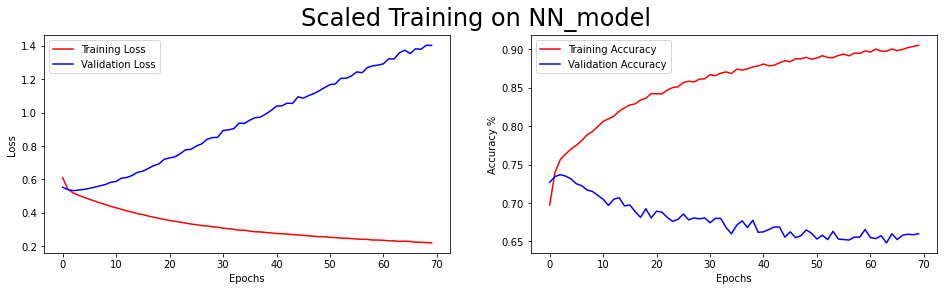

In [176]:
# plot train and val acc as a function of epochs
# your code here
fig, ax = plt.subplots(1,2,figsize = (16,4))

ax[0].plot(history.history['loss'],'r',label = 'Training Loss')
ax[0].plot(history.history['val_loss'],'b',label = 'Validation Loss')
ax[1].plot(history.history['accuracy'],'r',label = 'Training Accuracy')
ax[1].plot(history.history['val_accuracy'],'b',label = 'Validation Accuracy')
ax[0].legend()
ax[1].legend()
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs');
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Accuracy %');
fig.suptitle('Scaled Training on NN_model', fontsize = 24)

In [177]:
# evaluate on train and test and print accuracy results
# your code here 
train_accuracy = NN_model_scaled.evaluate(X_train,y_train)[1]
test_accuracy = NN_model_scaled.evaluate(X_test,y_test)[1]
print(f'The training set accuracy for the model is {train_accuracy}\\n The test set accuracy for the model is {test_accuracy}')

63/63 [==============================] - 0s 1ms/step - loss: 1.4455 - accuracy: 0.6408
The training set accuracy for the model is 0.8673086762428284\n The test set accuracy for the model is 0.6408203840255737


Its clear that this model is really overfitting badly as the validation accuracy almost immediately starts going down. I'm honestly not sure why this is and tried to do a LOT of things to fix it with no luck. I have added my unscaled model below to show that the model works, however, something about the nature of my scaling is causing issues. I tried two different scaling methods with similar results. 

Model: "NN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 15)                12165     
_________________________________________________________________
hidden2 (Dense)              (None, 15)                240       
_________________________________________________________________
output (Dense)               (None, 1)                 16        
Total params: 12,421
Trainable params: 12,421
Non-trainable params: 0
_________________________________________________________________
CPU times: user 16.4 s, sys: 4.29 s, total: 20.6 s
Wall time: 10.7 s


Text(0.5, 0.98, 'Unscaled Training on NN_model')

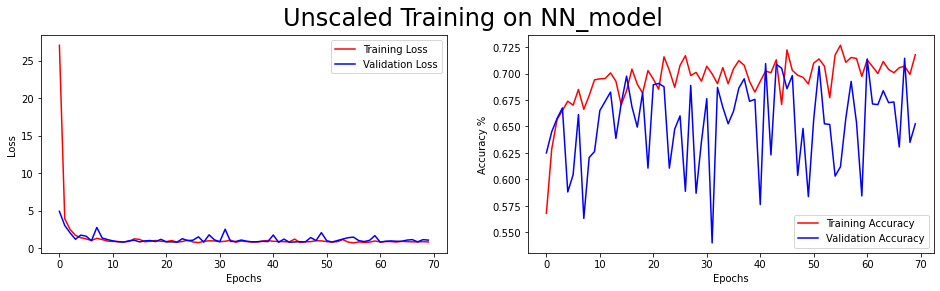

In [126]:
%%time
# compile it and run it
#optimizer = optimizers.Adam(lr=0.01) 

NN_model.compile(optimizer = 'adam',loss='binary_crossentropy',  metrics = ['accuracy']) 

NN_model.summary()

history = NN_model.fit(X_train_us, y_train_us,validation_data=(X_test_us,y_test_us), epochs=70, verbose = 0, validation_split=.2) 

fig, ax = plt.subplots(1,2,figsize = (16,4))

ax[0].plot(history.history['loss'],'r',label = 'Training Loss')
ax[0].plot(history.history['val_loss'],'b',label = 'Validation Loss')
ax[1].plot(history.history['accuracy'],'r',label = 'Training Accuracy')
ax[1].plot(history.history['val_accuracy'],'b',label = 'Validation Accuracy')
ax[0].legend()
ax[1].legend()
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs');
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Accuracy %');
fig.suptitle('Unscaled Training on NN_model', fontsize = 24)

In [127]:
train_accuracy = NN_model.evaluate(X_train_us,y_train_us)[1]
test_accuracy = NN_model.evaluate(X_test_us,y_test_us)[1]
print('note that the test accuracy is slightly higher on my unscaled set')
print(f'The training set accuracy for the unscaled model is {train_accuracy}\\n The test set accuracy for the unscaled model is {test_accuracy}')

63/63 [==============================] - 0s 967us/step - loss: 1.0931 - accuracy: 0.6643
note that the test accuracy is slightly higher on my unscaled set
The training set accuracy for the unscaled model is 0.6927213668823242\n The test set accuracy for the unscaled model is 0.6643321514129639


<a id="s13"></a>
<div class='exercise-r'>

**[1.3:](#q13) Fit and examine a "proxy" model**

To begin our interpretation of the resulting `NN_model`, we will first use a "proxy model" that we know how to interpret and train it on our `NN_model` class predictions rather than the true $y$ training values.
    
**[1.3.1:](#q13)** First, generate a set of `NN_model` class predictions for the training set. These $\hat{y}$ training predictions will be used instead of the true $y$ training values when we fit our proxy model in 1.3.2. The $X$ values used in our 1.3.2 proxy model should be the same ones used for `NN_model`.

</div>

In [128]:
# generate y_pred off of our y_train data

y_pred = pd.DataFrame(NN_model.predict(X_train_us))

for index,row in y_pred.iterrows():
    
    if row[0] > .5:
        y_pred.iloc[index] = 1
    else:
        row[0] = 0
y_pred

,0
0,1.0
1,0.0
2,0.0
3,0.0
4,1.0
...,...
7991,1.0
7992,0.0
7993,0.0
7994,1.0


<a id="s132"></a>
<div class='exercise-r'>
    
**[1.3.2:](#q13)** Next, fit a logistic regression model using your $\hat{y}$ values from 1.3.1 (name this model `logreg`). Use ridge-like regularization. Print the `logreg` test accuracy to confirm that it is similar to what we saw for our `NN_model` test accuracy in 1.2. You may need to adjust `C` in order to achieve a similar accuracy.

</div>

In [129]:
log_reg = LogisticRegression(C=.001, penalty='l2',solver='lbfgs', max_iter = 10000)
log_reg.fit(X_train, y_train)
score = log_reg.score(X_test,y_test)

print(f'logreg test accuracy {score}')
print('note that the test accuracy is actually higher than I received in my NN_model')

logreg test accuracy 0.6863431715857929
note that the test accuracy is actually higher than I received in my NN_model


/Users/stevenmorse/opt/anaconda3/envs/cs109a_3_7/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


<a id="s133"></a>
<div class='exercise-r'>

**[1.3.3:](#q13)** Now use sklearn's `permutation_importance` function (already included in this notebook's imports) to compute the feature importance using the `logreg` model. Plot the **relative** feature importance for the top-10 most important predictors identified by the `permutation_importance` function.

  - Please refer to sklearn's official documentation to learn how this function works.
  
  - When running `permutation_importance` for this problem, you can use the default number of `n_repeats` and your estimator's default `scorer`. To speed up the time it takes to run your permutations, you can try setting `n_jobs=-1` to take full advantage of all of your available processor cores.

</div>

In [130]:
# your code here
result = permutation_importance(log_reg, X_train, y_pred, n_repeats=10, n_jobs=-1)


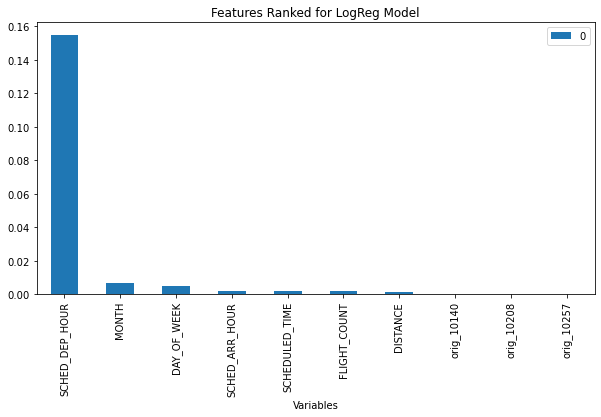

In [131]:
importance_df = (pd.DataFrame(result.importances_mean[0:10])).abs()
#importance_df['variable'] = list(X.columns.values)
column_names = list(X.columns.values)
importance_df = importance_df.sort_values(by=[0],ascending =False)

#create sorted list of the variable names that matches the weights
sorted_columns = []
for index, row in importance_df.iterrows():
    sorted_columns.append(column_names[index])

#add the variable labels to the dataframe
importance_df['Variables'] = sorted_columns

#plot df
importance_df.plot(x = 'Variables', y = 0, kind ='bar', title = 'Features Ranked for LogReg Model', figsize = (10,5))
plt.show()

<a id="s14"></a>
<div class='exercise-r'>

**[1.4:](#q14) Visualize important features**

Another way to interpret the  `NN_model` is by examining the response as a function of any of the predictors. Particularly, we will select from features often found most significant from the analysis above. **For all 1.4 plots below**, for ease of interpretation, **please be certain to** display all predictors on their original scales. **NOTE:** The predictors you are required to use in 1.4 may differ from some of the top-10 predictors you identified in 1.3 as a result of random variability in our algorithms.

**[1.4.1:](#q14)** Set all predictors to their means/modes except for `SCHED_DEP_HOUR`. Predict the `NN_model` probability of delay and plot the predicted probabilities of delay vs. `SCHED_DEP_HOUR` on the data from the **training set**. Interpret what you see in 2-4 sentences. 

</div>

In [158]:
X_train_41 =X_train_us.copy()

In [159]:
i = 0
for column in X_train_41:
    if i<=5 and i!=3:
        X_train_41[column] = X_train_41[column].mean()
    if i>5 and i!=3:
        mode = X_train_41[column].mode()
        X_train_41[column] = mode[0]
    i = i + 1    

X_train_41

,DISTANCE,SCHEDULED_TIME,MONTH,SCHED_DEP_HOUR,SCHED_ARR_HOUR,FLIGHT_COUNT,DAY_OF_WEEK,orig_10140,orig_10208,orig_10257,orig_10279,orig_10372,orig_10397,orig_10423,orig_10529,orig_10620,orig_10693,orig_10713,orig_10721,orig_10747,orig_10779,orig_10781,orig_10792,orig_10800,orig_10821,orig_10868,orig_10874,orig_10990,orig_10994,orig_11042,orig_11049,orig_11057,orig_11066,orig_11109,orig_11193,orig_11259,orig_11267,orig_11278,orig_11292,orig_11298,orig_11315,orig_11413,orig_11423,orig_11433,orig_11540,orig_11603,orig_11612,orig_11618,orig_11638,orig_11695,orig_11697,orig_11823,orig_11884,orig_11953,orig_11973,orig_11977,orig_11986,orig_11995,orig_11996,orig_12156,orig_12173,orig_12191,orig_12206,orig_12264,orig_12266,orig_12339,orig_12389,orig_12391,orig_12451,orig_12478,orig_12758,orig_12889,orig_12892,orig_12896,orig_12953,orig_12954,orig_12992,orig_13061,orig_13158,orig_13198,orig_13204,orig_13230,orig_13232,orig_13290,orig_13303,orig_13342,orig_13367,orig_13377,orig_13422,orig_13433,orig_13487,orig_13495,orig_13577,orig_13796,orig_13851,orig_13871,orig_13891,orig_13930,orig_13931,orig_14027,orig_14057,orig_14098,orig_14100,orig_14107,orig_14108,orig_14122,orig_14150,orig_14193,orig_14252,orig_14262,orig_14307,orig_14489,orig_14492,orig_14524,orig_14570,orig_14635,orig_14679,orig_14683,orig_14689,orig_14698,orig_14730,orig_14747,orig_14771,orig_14783,orig_14831,orig_14843,orig_14869,orig_14893,orig_14908,orig_15016,orig_15304,orig_15370,orig_15376,orig_15411,orig_15412,orig_15624,orig_15919,orig_16218,orig_ABE,orig_ABI,orig_ABQ,orig_ABY,orig_ACT,orig_ACV,orig_ACY,orig_ADQ,orig_AEX,orig_AGS,orig_AKN,orig_ALB,orig_AMA,orig_ANC,orig_ASE,orig_ATL,orig_ATW,orig_AUS,orig_AVL,orig_AVP,orig_AZO,orig_BDL,orig_BFL,orig_BGM,orig_BHM,orig_BIL,orig_BIS,orig_BJI,orig_BLI,orig_BMI,orig_BNA,orig_BOI,orig_BOS,orig_BPT,orig_BQN,orig_BRD,orig_BRO,orig_BRW,orig_BTM,orig_BTR,orig_BTV,orig_BUF,orig_BUR,orig_BWI,orig_BZN,orig_CAE,orig_CAK,orig_CDV,orig_CHA,orig_CHO,orig_CHS,orig_CID,orig_CIU,orig_CLD,orig_CLE,orig_CLL,orig_CLT,orig_CMH,orig_CMI,orig_COS,orig_COU,orig_CPR,orig_CRP,orig_CRW,orig_CVG,orig_CWA,orig_DAB,orig_DAL,orig_DAY,orig_DCA,orig_DEN,orig_DFW,orig_DIK,orig_DLH,orig_DRO,orig_DSM,orig_DTW,orig_DVL,orig_EAU,orig_ECP,orig_EGE,orig_EKO,orig_ELM,orig_ELP,orig_ERI,orig_ESC,orig_EUG,orig_EVV,orig_EWR,orig_EYW,orig_FAI,orig_FAR,orig_FAT,orig_FAY,orig_FCA,orig_FLG,orig_FLL,orig_FNT,orig_FSD,orig_FSM,orig_FWA,orig_GCK,orig_GEG,orig_GFK,orig_GGG,orig_GJT,orig_GNV,orig_GPT,orig_GRB,orig_GRK,orig_GRR,orig_GSO,orig_GSP,orig_GTF,orig_GTR,orig_GUC,orig_GUM,orig_HNL,orig_HOB,orig_HOU,orig_HPN,orig_HRL,orig_HSV,orig_HYS,orig_IAD,orig_IAH,orig_ICT,orig_IDA,orig_ILM,orig_IND,orig_INL,orig_ISN,orig_ISP,orig_ITO,orig_JAC,orig_JAN,orig_JAX,orig_JFK,orig_JMS,orig_JNU,orig_KOA,orig_KTN,orig_LAN,orig_LAS,orig_LAW,orig_LAX,orig_LBB,orig_LBE,orig_LCH,orig_LEX,orig_LFT,orig_LGA,orig_LGB,orig_LIH,orig_LIT,orig_LNK,orig_LRD,orig_LSE,orig_LWS,orig_MAF,orig_MBS,orig_MCI,orig_MCO,orig_MDT,orig_MDW,orig_MEI,orig_MEM,orig_MFE,orig_MFR,orig_MGM,orig_MHK,orig_MHT,orig_MIA,orig_MKE,orig_MKG,orig_MLB,orig_MLI,orig_MLU,orig_MOB,orig_MOT,orig_MRY,orig_MSN,orig_MSO,orig_MSP,orig_MSY,orig_MTJ,orig_MYR,orig_OAJ,orig_OAK,orig_OGG,orig_OKC,orig_OMA,orig_OME,orig_ONT,orig_ORD,orig_ORF,orig_ORH,orig_OTZ,orig_PAH,orig_PBG,orig_PBI,orig_PDX,orig_PHF,orig_PHL,orig_PHX,orig_PIA,orig_PIH,orig_PIT,orig_PLN,orig_PNS,orig_PSC,orig_PSE,orig_PSP,orig_PUB,orig_PVD,orig_PWM,orig_RAP,orig_RDD,orig_RDM,orig_RDU,orig_RIC,orig_RKS,orig_RNO,orig_ROA,orig_ROC,orig_RST,orig_RSW,orig_SAF,orig_SAN,orig_SAT,orig_SAV,orig_SBA,orig_SBN,orig_SBP,orig_SCE,orig_SDF,orig_SEA,orig_SFO,orig_SGF,orig_SGU,orig_SHV,orig_SIT,orig_SJC,orig_SJT,orig_SJU,orig_SLC,orig_SMF,orig_SNA,orig_SPI,orig_SPS,orig_SRQ,orig_STL,orig_STT,orig_STX,orig_SUN,orig_SUX,orig_SWF,orig_SYR,orig_TLH,orig_TOL,orig_TPA,orig_TRI,orig_TTN,orig_TUL,orig_TUS,orig_TVC,orig_TYR,orig_TYS,orig_VLD,orig_VPS,orig_WRG,orig_XNA,orig_YAK,orig_YUM,dest_10

In [160]:
y_pred = pd.DataFrame(NN_model.predict(X_train_41), columns = ['y_pred'])
y_pred_preprocessed = y_pred.copy()
#trained on unscaled model to preserve hours

In [161]:
pred = []
#didn't need to do this step below and preprocessing vs processed
for index,row in y_pred.iterrows():
    pred_row = row[0]
    if pred_row >= .5:
        pred.append(1)
    else:
        pred.append(0)
        
y_pred[0] = pred

plotting_df = pd.concat([X_train_41['SCHED_DEP_HOUR'].reset_index(drop=True),y_pred_preprocessed.reset_index(drop=True)], axis=1)

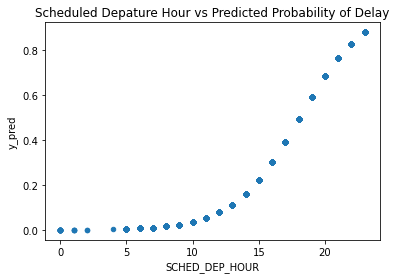

In [162]:
plotting_df.plot( x = 'SCHED_DEP_HOUR' , y = 'y_pred', kind = 'scatter')
plt.title('Scheduled Depature Hour vs Predicted Probability of Delay')
plt.show()

I worked really hard on this homework and was nearly completed with it, however I got really sick tonight. There was some low hanging fruit that I couldn't get to on some of the middle portion around the 1.4-1.6 area. I completed most of it, but my stamina is completely shot from throwing up tonight. Sorry I couldn't complete this portion. 

**INTERPRETATION:**

Our chart shows that the greater the time, the more likely the delay is to occur. There seems to be some clear correlation between the scheduled departure hour and the likelihood of a delay. I tried this on both the scaled and unscaled X_trains, I felt this was more descriptive since it retained the schedule departure hour in its original scale, however the slope of the curve was steeper on the scaled version. 

<a id="s142"></a>
<div class='exercise-r'>

**[1.4.2:](#q14)** Set all predictors to their means/modes except for `SCHED_DEP_HOUR` and `FLIGHT_COUNT`. Predict the `NN_model` probability of delay and plot the predicted probabilities of delay vs. `SCHED_DEP_HOUR` and `FLIGHT_COUNT` from the training set (see the question 1.4 "HINT" below).

**HINT:** For 1.4.2, 1.4.3, and 1.4.4, when you include `SCHED_DEP_HOUR` on one axis and your second predictor on the other axis, you can color your data points based on their corresponding predicted probabilities by using  the `c` and `cmap` arguments in `plt.scatter`. You can also add a labeled colorbar to your plot to make clear what those colors mean. Please refer to the matplotlib documentation for examples.

</div>

In [145]:
X_train_42 =X_train_us.copy()

In [152]:
i = 0
for column in X_train_42:
    if i<=5 and i!=3 and i!=5:
        X_train_42[column] = X_train_42[column].mean()
    if i>5 and i!=3 and i!=5:
        mode = X_train_42[column].mode()
        X_train_42[column] = mode[0]
    i = i + 1    

X_train_42[['SCHED_DEP_HOUR','FLIGHT_COUNT']]


,SCHED_DEP_HOUR,FLIGHT_COUNT
4315,19,180.0
7176,9,182.0
6731,6,67.0
7326,8,581.0
5307,18,45.0
...,...,...
7495,18,127.0
8878,7,124.0
7448,19,217.0
4185,22,17.0


In [157]:
plotting_df

,SCHED_DEP_HOUR,FLIGHT_COUNT,y_pred
0,19,180.0,0.598656
1,9,182.0,0.025564
2,6,67.0,0.008324
3,8,581.0,0.010645
4,18,45.0,0.540148
...,...,...,...
7991,18,127.0,0.515199
7992,7,124.0,0.012222
7993,19,217.0,0.587753
7994,22,17.0,0.859419


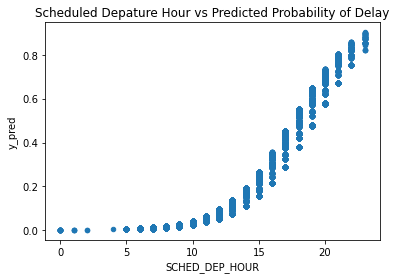

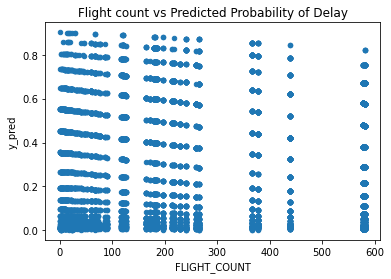

In [156]:
y_pred = pd.DataFrame(NN_model.predict(X_train_42), columns = ['y_pred'])
y_pred_preprocessed = y_pred.copy()
#X_train_select = pd.DataFrame(X_train_42['SCHED_DEP_HOUR','FLIGHT_COUNT'], columns = ['SCHED_DEP_HOUR','FLIGHT_COUNT'])
#X_train_select
plotting_df = pd.concat([X_train_42[['SCHED_DEP_HOUR','FLIGHT_COUNT']].reset_index(drop=True),y_pred_preprocessed.reset_index(drop=True)], axis=1)
plotting_df.plot( x = 'SCHED_DEP_HOUR' , y = 'y_pred', kind = 'scatter')
plt.title('Scheduled Depature Hour vs Predicted Probability of Delay')
plt.show()

plotting_df.plot( x = 'FLIGHT_COUNT' , y = 'y_pred', kind = 'scatter')
plt.title('Flight count vs Predicted Probability of Delay')
plt.show()


<a id="s143"></a>
<div class='exercise-r'>

**[1.4.3:](#q14)** Set all predictors to their means/modes except for except for `SCHED_DEP_HOUR` and `SCHED_ARR_HOUR`. Predict the `NN_model` probability of delay and plot the predicted probabilities of delay vs. `SCHED_DEP_HOUR` and `SCHED_ARR_HOUR` from the training set.
    
</div>

In [191]:
X_train_43 =X_train_us.copy()

In [192]:
# your code here
i = 0
for column in X_train_43:
    if i<=5 and i!=3 and i!=4:
        X_train_43[column] = X_train_43[column].mean()
    if i>5 and i!=3 and i!=4:
        mode = X_train_43[column].mode()
        X_train_43[column] = mode[0]
    i = i + 1    

X_train_43

,DISTANCE,SCHEDULED_TIME,MONTH,SCHED_DEP_HOUR,SCHED_ARR_HOUR,FLIGHT_COUNT,DAY_OF_WEEK,orig_10140,orig_10208,orig_10257,orig_10279,orig_10372,orig_10397,orig_10423,orig_10529,orig_10620,orig_10693,orig_10713,orig_10721,orig_10747,orig_10779,orig_10781,orig_10792,orig_10800,orig_10821,orig_10868,orig_10874,orig_10990,orig_10994,orig_11042,orig_11049,orig_11057,orig_11066,orig_11109,orig_11193,orig_11259,orig_11267,orig_11278,orig_11292,orig_11298,orig_11315,orig_11413,orig_11423,orig_11433,orig_11540,orig_11603,orig_11612,orig_11618,orig_11638,orig_11695,orig_11697,orig_11823,orig_11884,orig_11953,orig_11973,orig_11977,orig_11986,orig_11995,orig_11996,orig_12156,orig_12173,orig_12191,orig_12206,orig_12264,orig_12266,orig_12339,orig_12389,orig_12391,orig_12451,orig_12478,orig_12758,orig_12889,orig_12892,orig_12896,orig_12953,orig_12954,orig_12992,orig_13061,orig_13158,orig_13198,orig_13204,orig_13230,orig_13232,orig_13290,orig_13303,orig_13342,orig_13367,orig_13377,orig_13422,orig_13433,orig_13487,orig_13495,orig_13577,orig_13796,orig_13851,orig_13871,orig_13891,orig_13930,orig_13931,orig_14027,orig_14057,orig_14098,orig_14100,orig_14107,orig_14108,orig_14122,orig_14150,orig_14193,orig_14252,orig_14262,orig_14307,orig_14489,orig_14492,orig_14524,orig_14570,orig_14635,orig_14679,orig_14683,orig_14689,orig_14698,orig_14730,orig_14747,orig_14771,orig_14783,orig_14831,orig_14843,orig_14869,orig_14893,orig_14908,orig_15016,orig_15304,orig_15370,orig_15376,orig_15411,orig_15412,orig_15624,orig_15919,orig_16218,orig_ABE,orig_ABI,orig_ABQ,orig_ABY,orig_ACT,orig_ACV,orig_ACY,orig_ADQ,orig_AEX,orig_AGS,orig_AKN,orig_ALB,orig_AMA,orig_ANC,orig_ASE,orig_ATL,orig_ATW,orig_AUS,orig_AVL,orig_AVP,orig_AZO,orig_BDL,orig_BFL,orig_BGM,orig_BHM,orig_BIL,orig_BIS,orig_BJI,orig_BLI,orig_BMI,orig_BNA,orig_BOI,orig_BOS,orig_BPT,orig_BQN,orig_BRD,orig_BRO,orig_BRW,orig_BTM,orig_BTR,orig_BTV,orig_BUF,orig_BUR,orig_BWI,orig_BZN,orig_CAE,orig_CAK,orig_CDV,orig_CHA,orig_CHO,orig_CHS,orig_CID,orig_CIU,orig_CLD,orig_CLE,orig_CLL,orig_CLT,orig_CMH,orig_CMI,orig_COS,orig_COU,orig_CPR,orig_CRP,orig_CRW,orig_CVG,orig_CWA,orig_DAB,orig_DAL,orig_DAY,orig_DCA,orig_DEN,orig_DFW,orig_DIK,orig_DLH,orig_DRO,orig_DSM,orig_DTW,orig_DVL,orig_EAU,orig_ECP,orig_EGE,orig_EKO,orig_ELM,orig_ELP,orig_ERI,orig_ESC,orig_EUG,orig_EVV,orig_EWR,orig_EYW,orig_FAI,orig_FAR,orig_FAT,orig_FAY,orig_FCA,orig_FLG,orig_FLL,orig_FNT,orig_FSD,orig_FSM,orig_FWA,orig_GCK,orig_GEG,orig_GFK,orig_GGG,orig_GJT,orig_GNV,orig_GPT,orig_GRB,orig_GRK,orig_GRR,orig_GSO,orig_GSP,orig_GTF,orig_GTR,orig_GUC,orig_GUM,orig_HNL,orig_HOB,orig_HOU,orig_HPN,orig_HRL,orig_HSV,orig_HYS,orig_IAD,orig_IAH,orig_ICT,orig_IDA,orig_ILM,orig_IND,orig_INL,orig_ISN,orig_ISP,orig_ITO,orig_JAC,orig_JAN,orig_JAX,orig_JFK,orig_JMS,orig_JNU,orig_KOA,orig_KTN,orig_LAN,orig_LAS,orig_LAW,orig_LAX,orig_LBB,orig_LBE,orig_LCH,orig_LEX,orig_LFT,orig_LGA,orig_LGB,orig_LIH,orig_LIT,orig_LNK,orig_LRD,orig_LSE,orig_LWS,orig_MAF,orig_MBS,orig_MCI,orig_MCO,orig_MDT,orig_MDW,orig_MEI,orig_MEM,orig_MFE,orig_MFR,orig_MGM,orig_MHK,orig_MHT,orig_MIA,orig_MKE,orig_MKG,orig_MLB,orig_MLI,orig_MLU,orig_MOB,orig_MOT,orig_MRY,orig_MSN,orig_MSO,orig_MSP,orig_MSY,orig_MTJ,orig_MYR,orig_OAJ,orig_OAK,orig_OGG,orig_OKC,orig_OMA,orig_OME,orig_ONT,orig_ORD,orig_ORF,orig_ORH,orig_OTZ,orig_PAH,orig_PBG,orig_PBI,orig_PDX,orig_PHF,orig_PHL,orig_PHX,orig_PIA,orig_PIH,orig_PIT,orig_PLN,orig_PNS,orig_PSC,orig_PSE,orig_PSP,orig_PUB,orig_PVD,orig_PWM,orig_RAP,orig_RDD,orig_RDM,orig_RDU,orig_RIC,orig_RKS,orig_RNO,orig_ROA,orig_ROC,orig_RST,orig_RSW,orig_SAF,orig_SAN,orig_SAT,orig_SAV,orig_SBA,orig_SBN,orig_SBP,orig_SCE,orig_SDF,orig_SEA,orig_SFO,orig_SGF,orig_SGU,orig_SHV,orig_SIT,orig_SJC,orig_SJT,orig_SJU,orig_SLC,orig_SMF,orig_SNA,orig_SPI,orig_SPS,orig_SRQ,orig_STL,orig_STT,orig_STX,orig_SUN,orig_SUX,orig_SWF,orig_SYR,orig_TLH,orig_TOL,orig_TPA,orig_TRI,orig_TTN,orig_TUL,orig_TUS,orig_TVC,orig_TYR,orig_TYS,orig_VLD,orig_VPS,orig_WRG,orig_XNA,orig_YAK,orig_YUM,dest_10

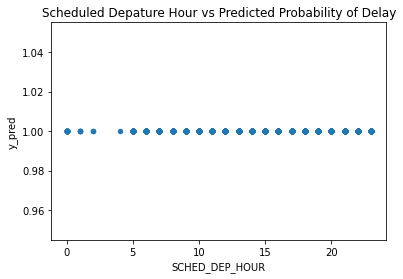

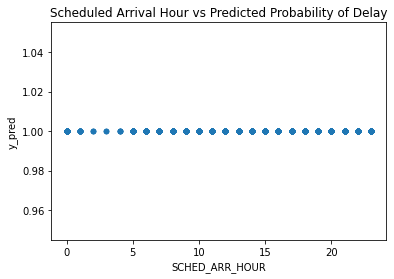

In [194]:
#trained on unscaled model to preserve hours
y_pred = pd.DataFrame(NN_model.predict(X_train_43), columns = ['y_pred'])
y_pred_preprocessed = y_pred.copy()
#X_train_select = pd.DataFrame(X_train_42['SCHED_DEP_HOUR','FLIGHT_COUNT'], columns = ['SCHED_DEP_HOUR','FLIGHT_COUNT'])
#X_train_select
plotting_df = pd.concat([X_train_43[['SCHED_DEP_HOUR','SCHED_ARR_HOUR']].reset_index(drop=True),y_pred_preprocessed.reset_index(drop=True)], axis=1)
plotting_df.plot( x = 'SCHED_DEP_HOUR' , y = 'y_pred', kind = 'scatter')
plt.title('Scheduled Depature Hour vs Predicted Probability of Delay')
plt.show()

plotting_df.plot( x = 'SCHED_ARR_HOUR' , y = 'y_pred', kind = 'scatter')
plt.title('Scheduled Arrival Hour vs Predicted Probability of Delay')
plt.show()


<a id="s144"></a>
<div class='exercise-r'>

**[1.4.4:](#q14)** Set all predictors to their means/modes except for except for `SCHED_DEP_HOUR` and `DISTANCE`. Predict the `NN_model` probability of delay and plot the predicted probabilities of delay vs. `SCHED_DEP_HOUR` and `DISTANCE` from the training set.
    
</div>

In [138]:
X_train_44 =X_train_us.copy()

In [139]:
# your code here
i = 0
for column in X_train_44:
    if i<=5 and i!=3 and i!=0:
        X_train_44[column] = X_train_44[column].mean()
    if i>5 and i!=3 and i!=0:
        mode = X_train_44[column].mode()
        X_train_44[column] = mode[0]
    i = i + 1    

X_train_44

,DISTANCE,SCHEDULED_TIME,MONTH,SCHED_DEP_HOUR,SCHED_ARR_HOUR,FLIGHT_COUNT,DAY_OF_WEEK,orig_10140,orig_10208,orig_10257,orig_10279,orig_10372,orig_10397,orig_10423,orig_10529,orig_10620,orig_10693,orig_10713,orig_10721,orig_10747,orig_10779,orig_10781,orig_10792,orig_10800,orig_10821,orig_10868,orig_10874,orig_10990,orig_10994,orig_11042,orig_11049,orig_11057,orig_11066,orig_11109,orig_11193,orig_11259,orig_11267,orig_11278,orig_11292,orig_11298,orig_11315,orig_11413,orig_11423,orig_11433,orig_11540,orig_11603,orig_11612,orig_11618,orig_11638,orig_11695,orig_11697,orig_11823,orig_11884,orig_11953,orig_11973,orig_11977,orig_11986,orig_11995,orig_11996,orig_12156,orig_12173,orig_12191,orig_12206,orig_12264,orig_12266,orig_12339,orig_12389,orig_12391,orig_12451,orig_12478,orig_12758,orig_12889,orig_12892,orig_12896,orig_12953,orig_12954,orig_12992,orig_13061,orig_13158,orig_13198,orig_13204,orig_13230,orig_13232,orig_13290,orig_13303,orig_13342,orig_13367,orig_13377,orig_13422,orig_13433,orig_13487,orig_13495,orig_13577,orig_13796,orig_13851,orig_13871,orig_13891,orig_13930,orig_13931,orig_14027,orig_14057,orig_14098,orig_14100,orig_14107,orig_14108,orig_14122,orig_14150,orig_14193,orig_14252,orig_14262,orig_14307,orig_14489,orig_14492,orig_14524,orig_14570,orig_14635,orig_14679,orig_14683,orig_14689,orig_14698,orig_14730,orig_14747,orig_14771,orig_14783,orig_14831,orig_14843,orig_14869,orig_14893,orig_14908,orig_15016,orig_15304,orig_15370,orig_15376,orig_15411,orig_15412,orig_15624,orig_15919,orig_16218,orig_ABE,orig_ABI,orig_ABQ,orig_ABY,orig_ACT,orig_ACV,orig_ACY,orig_ADQ,orig_AEX,orig_AGS,orig_AKN,orig_ALB,orig_AMA,orig_ANC,orig_ASE,orig_ATL,orig_ATW,orig_AUS,orig_AVL,orig_AVP,orig_AZO,orig_BDL,orig_BFL,orig_BGM,orig_BHM,orig_BIL,orig_BIS,orig_BJI,orig_BLI,orig_BMI,orig_BNA,orig_BOI,orig_BOS,orig_BPT,orig_BQN,orig_BRD,orig_BRO,orig_BRW,orig_BTM,orig_BTR,orig_BTV,orig_BUF,orig_BUR,orig_BWI,orig_BZN,orig_CAE,orig_CAK,orig_CDV,orig_CHA,orig_CHO,orig_CHS,orig_CID,orig_CIU,orig_CLD,orig_CLE,orig_CLL,orig_CLT,orig_CMH,orig_CMI,orig_COS,orig_COU,orig_CPR,orig_CRP,orig_CRW,orig_CVG,orig_CWA,orig_DAB,orig_DAL,orig_DAY,orig_DCA,orig_DEN,orig_DFW,orig_DIK,orig_DLH,orig_DRO,orig_DSM,orig_DTW,orig_DVL,orig_EAU,orig_ECP,orig_EGE,orig_EKO,orig_ELM,orig_ELP,orig_ERI,orig_ESC,orig_EUG,orig_EVV,orig_EWR,orig_EYW,orig_FAI,orig_FAR,orig_FAT,orig_FAY,orig_FCA,orig_FLG,orig_FLL,orig_FNT,orig_FSD,orig_FSM,orig_FWA,orig_GCK,orig_GEG,orig_GFK,orig_GGG,orig_GJT,orig_GNV,orig_GPT,orig_GRB,orig_GRK,orig_GRR,orig_GSO,orig_GSP,orig_GTF,orig_GTR,orig_GUC,orig_GUM,orig_HNL,orig_HOB,orig_HOU,orig_HPN,orig_HRL,orig_HSV,orig_HYS,orig_IAD,orig_IAH,orig_ICT,orig_IDA,orig_ILM,orig_IND,orig_INL,orig_ISN,orig_ISP,orig_ITO,orig_JAC,orig_JAN,orig_JAX,orig_JFK,orig_JMS,orig_JNU,orig_KOA,orig_KTN,orig_LAN,orig_LAS,orig_LAW,orig_LAX,orig_LBB,orig_LBE,orig_LCH,orig_LEX,orig_LFT,orig_LGA,orig_LGB,orig_LIH,orig_LIT,orig_LNK,orig_LRD,orig_LSE,orig_LWS,orig_MAF,orig_MBS,orig_MCI,orig_MCO,orig_MDT,orig_MDW,orig_MEI,orig_MEM,orig_MFE,orig_MFR,orig_MGM,orig_MHK,orig_MHT,orig_MIA,orig_MKE,orig_MKG,orig_MLB,orig_MLI,orig_MLU,orig_MOB,orig_MOT,orig_MRY,orig_MSN,orig_MSO,orig_MSP,orig_MSY,orig_MTJ,orig_MYR,orig_OAJ,orig_OAK,orig_OGG,orig_OKC,orig_OMA,orig_OME,orig_ONT,orig_ORD,orig_ORF,orig_ORH,orig_OTZ,orig_PAH,orig_PBG,orig_PBI,orig_PDX,orig_PHF,orig_PHL,orig_PHX,orig_PIA,orig_PIH,orig_PIT,orig_PLN,orig_PNS,orig_PSC,orig_PSE,orig_PSP,orig_PUB,orig_PVD,orig_PWM,orig_RAP,orig_RDD,orig_RDM,orig_RDU,orig_RIC,orig_RKS,orig_RNO,orig_ROA,orig_ROC,orig_RST,orig_RSW,orig_SAF,orig_SAN,orig_SAT,orig_SAV,orig_SBA,orig_SBN,orig_SBP,orig_SCE,orig_SDF,orig_SEA,orig_SFO,orig_SGF,orig_SGU,orig_SHV,orig_SIT,orig_SJC,orig_SJT,orig_SJU,orig_SLC,orig_SMF,orig_SNA,orig_SPI,orig_SPS,orig_SRQ,orig_STL,orig_STT,orig_STX,orig_SUN,orig_SUX,orig_SWF,orig_SYR,orig_TLH,orig_TOL,orig_TPA,orig_TRI,orig_TTN,orig_TUL,orig_TUS,orig_TVC,orig_TYR,orig_TYS,orig_VLD,orig_VPS,orig_WRG,orig_XNA,orig_YAK,orig_YUM,dest_10

In [140]:
y_pred = pd.DataFrame(NN_model.predict(X_train_44))

pred = []
for index,row in y_pred.iterrows():
    pred_row = row[0]
    if pred_row >= .5:
        pred.append(1)
    else:
        pred.append(0)
        
y_pred[0] = pred

test_accuracy = NN_model.evaluate(X_train,y_pred)[1]
test_accuracy

250/250 [==============================] - 0s 960us/step - loss: 1.5453 - accuracy: 0.6807


0.6807153820991516

<a id="s145"></a>
<div class='exercise-r'>

**[1.4.5:](#q14)** In 5-10 sentences, interpret what you have seen in 1.4.2, 1.4.3, and 1.4.4.
    
</div>

**INTERPRETATION:**

*Your answer here*


<a id="s15"></a>
<div class='exercise-r'>

**[1.5:](#q15) Bootstrap prediction intervals**

In this part, we will attempt to do model inference. Neural Networks have too many parameters, and therefore inference on all the parameters is intractable and meaningless. 

Using the same network architecture as `NN_model` (layers, nodes, activations, etc.) and your scaled data from that model, create multiple training sets using bootstrapping and fit a separate neural network model to each bootstrapped set of data (a minimum $n$ of at least 50 bootstraps should be used). Predict the output on the test data for each model. Randomly select 8 test observations and on 8 subplots, plot the distribution of predicted probabilities (i.e. $n$ bootstrapped probabilites) with the 95% prediction intervals clearly marked and reported in each subplot and the **actual** class of each observation included in each subplot's title for easy reference.
    
Interpret what you see in 3-5 sentences.

**NOTE:** The code for this problem can take an extremely long time to execute. Please feel free to use the `progressbar` function provided below to visually track the progress of your bootstraps.

</div>

In [167]:
def progressbar(n_step, n_total):
    """Prints self-updating progress bar to stdout to track for-loop progress
    
    
    There are entire 3rd-party libraries dedicated to custom progress-bars.
    A simple function like this is often more than enough to get the job done.
    
    :param n_total: total number of expected for-loop iterations
    :type n_total: int
    :param n_step: current iteration number, starting at 0
    :type n_step: int

    .. example::
    
        for i in range(n_iterations):
            progressbar(i, n_iterations)
            
    .. source:
    
        This function is a simplified version of code found here:
        https://stackoverflow.com/questions/3160699/python-progress-bar/15860757#15860757
    """
    n_step = n_step + 1
    barlen = 50
    progress = n_step / n_total
    block = int(round(barlen * progress))
    status = ""
    if n_step == n_total:
        status = "Done...\r\n\n"
    text = "\r [{0}] {1}/{2} {3}".format(
        "=" * block + "-" * (barlen - block),
        n_step,
        n_total,
        status,
    )
    sys.stdout.write(text)
    sys.stdout.flush()

In [172]:
%%time
# Bootstrap and train your networks and get predictions on X test
num_bootstraps = 50

y_pred_comb = pd.DataFrame()

for i in range(num_bootstraps):
          
    #bootstrap
    resample_indexes = np.random.choice(np.arange(y_train.shape[0]), size=y_train.shape[0])
    X_boot = X_train.iloc[resample_indexes]
    y_boot = y_train.iloc[resample_indexes]
    progressbar(i, num_bootstraps)
    NN_model.fit(X_boot,y_boot)
    y_pred = pd.DataFrame(NN_model_scaled.predict(X_test), columns = [i])

    y_pred_comb =  pd.concat([y_pred_comb.reset_index(drop=True), y_pred.reset_index(drop=True)], axis = 1)

y_pred_comb    

#finding the class predictions from all of the models then taking the average

250/250 [==============================] - 0s 2ms/step - loss: 0.1810 - accuracy: 0.9222
 [==================================================] 50/50 Done...

250/250 [==============================] - 0s 1ms/step - loss: 0.1735 - accuracy: 0.9245
CPU times: user 42.1 s, sys: 7.84 s, total: 50 s
Wall time: 39.2 s


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,0.129348,0.051878,0.078045,0.086194,0.063574,0.046613,0.049087,0.075666,0.022221,0.018433,0.026707,0.022318,0.040896,0.017795,0.016770,0.009856,0.034382,0.011118,0.018083,0.041547,0.053257,0.026698,0.014248,0.021675,0.007987,0.008263,0.017745,0.009320,0.017159,0.006427,0.011183,0.013274,0.006612,0.009597,0.003832,0.015443,0.008429,0.006492,0.005373,0.007640,0.006669,0.007003,0.004197,0.003271,0.002334,0.004127,0.006719,0.005778,0.006026,0.002514
1,0.988868,0.932162,0.993964,0.994165,0.970328,0.990003,0.955428,0.855990,0.989385,0.914281,0.955827,0.972926,0.939606,0.942215,0.777426,0.716537,0.980408,0.936217,0.993809,0.946767,0.924736,0.978323,0.902472,0.831308,0.896242,0.990529,0.951538,0.939077,0.802188,0.956499,0.918960,0.875904,0.965344,0.933247,0.963194,0.976680,0.910135,0.931382,0.797802,0.865866,0.968271,0.967752,0.983003,0.913988,0.818068,0.965360,0.990474,0.925989,0.985637,0.744746
2,0.869400,0.740843,0.975583,0.994670,0.933536,0.926515,0.847695,0.826050,0.908965,0.891159,0.782410,0.854432,0.910703,0.985090,0.926306,0.982227,0.991926,0.992191,0.988476,0.993490,0.971213,0.984711,0.939899,0.906081,0.765122,0.693487,0.908243,0.761509,0.595994,0.819120,0.637948,0.886640,0.575998,0.917373,0.850774,0.614532,0.760548,0.792674,0.837440,0.773416,0.689652,0.872872,0.710034,0.806547,0.639841,0.817256,0.945389,0.988685,0.860450,0.773392
3,0.347165,0.933426,0.880784,0.287244,0.321106,0.150854,0.125674,0.090060,0.297138,0.690961,0.192963,0.096016,0.288260,0.058940,0.704537,0.084254,0.557489,0.044827,0.398576,0.083869,0.032659,0.130018,0.302445,0.515320,0.201762,0.611235,0.040416,0.447472,0.939502,0.129217,0.223696,0.335364,0.078471,0.077522,0.144302,0.043284,0.086292,0.167724,0.438619,0.251149,0.158366,0.427270,0.664373,0.210851,0.090517,0.083734,0.354858,0.048131,0.236062,0.293327
4,0.006840,0.011488,0.008112,0.020080,0.001526,0.009542,0.004688,0.002003,0.001050,0.002731,0.001291,0.000985,0.003368,0.001281,0.002257,0.001405,0.005372,0.001472,0.005541,0.004575,0.002109,0.007050,0.002169,0.004523,0.000337,0.002548,0.000570,0.005197,0.030076,0.007888,0.000574,0.000772,0.000878,0.000629,0.002748,0.001419,0.000847,0.001130,0.000831,0.002447,0.000196,0.000549,0.000898,0.000583,0.000413,0.000119,0.000137,0.001235,0.000409,0.001247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1994,0.002676,0.002595,0.003027,0.003676,0.001459,0.003705,0.001617,0.000960,0.003291,0.002177,0.001371,0.001934,0.001359,0.001868,0.001252,0.001580,0.002143,0.002351,0.001423,0.000696,0.000741,0.000890,0.000490,0.000841,0.000503,0.000388,0.000498,0.000557,0.000748,0.000506,0.000510,0.000429,0.000671,0.000596,0.000379,0.000447,0.000364,0.000509,0.000318,0.000197,0.000189,0.000272,0.000207,0.000303,0.000272,0.000241,0.000314,0.000402,0.000308,0.000227
1995,0.971461,0.944021,0.945435,0.887616,0.968811,0.953103,0.953927,0.894873,0.978991,0.979234,0.924842,0.987496,0.979098,0.970677,0.965246,0.973100,0.969687,0.956541,0.954422,0.949166,0.982069,0.987464,0.934768,0.975585,0.969089,0.968212,0.946273,0.980099,0.941932,0.768388,0.971549,0.972960,0.994854,0.989663,0.983683,0.987590,0.984473,0.997607,0.996831,0.984023,0.988330,0.994145,0.961913,0.991234,0.993648,0.988962,0.953393,0.966356,0.986110,0.988046
1996,0.000954,0.000500,0.000783,0.000382,0.000950,0.000430,0.001135,0.001025,0.000495,0.000708,0.000308,0.000506,0.000248,0.000741,0.002483,0.000182,0.001219,0.000570,0.000532,0.001014,0.000216,0.000448,0.000285,0.000150,0.000070,0.000112,0.000142,0.000115,0.000120,0.000078,0.000069,0.000043,0.000044,0.000031,0.000132,0.000085,0.000046,0.000068,0.000035,0.000023,0.000072,0.000048,0.000043,0.000017,0.000005,0.000016,0.000012,0.000017,0.000043,0.000005
1997,0.063584,0.127024,0.12412

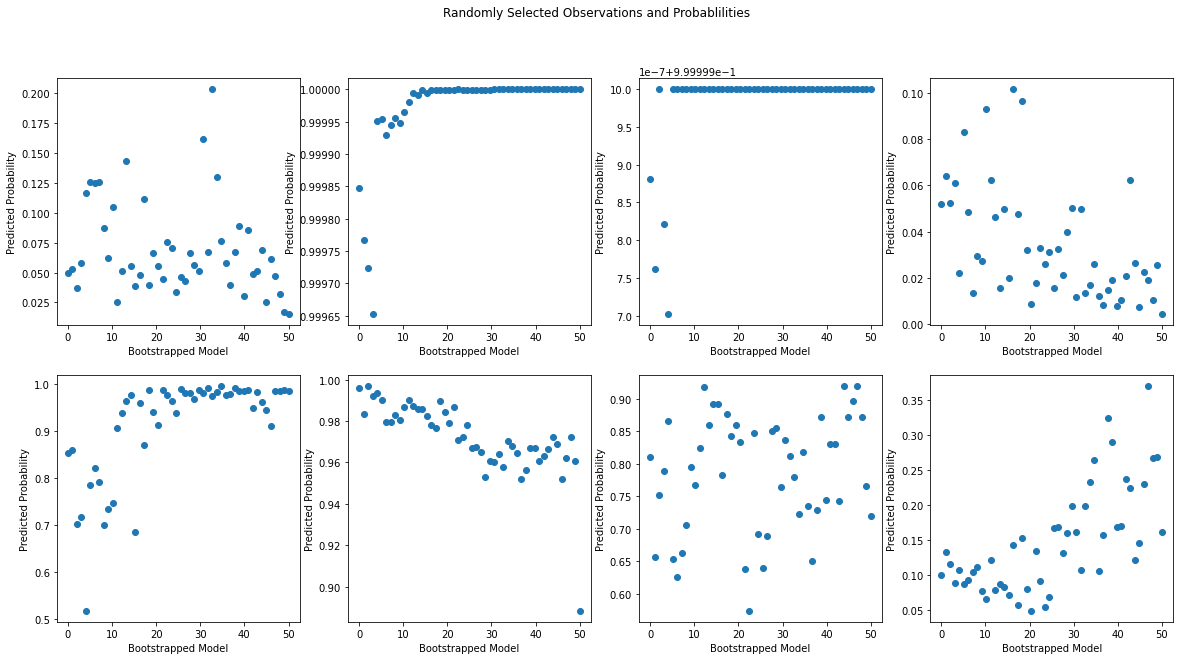

In [173]:
sequence = np.linspace(0, 1998, num=1998, endpoint=False)
eight_values = np.random.choice(sequence,8).astype(int)
y_rand = y_pred_comb.loc[eight_values]
y_rand
plot_test = y_rand.loc[eight_values[1]]

figure, ax = plt.subplots(2, 4, figsize = (20,10))
figure.suptitle('Randomly Selected Observations and Probablilities')
x = np.linspace(0.0,50,50)
count = 0
for i in range(2):    
    for j in range(4):
        ax[i, j].scatter(x, y_rand.loc[eight_values[count]])
        ax[i,j].set_ylabel('Predicted Probability')
        ax[i,j].set_xlabel('Bootstrapped Model')
        count = 1 + count 


""



\**INTERPRETATION:**

*Your answer here*


<a id="s16"></a>
<div class='exercise-r'>

**[1.6:](#q16) Build an "abstain" bagging model**

Using the probability distribution of the predictions obtained from the bootstrapped samples above, we can evaluate how "significant" our bagged (i.e. bootstrap-aggregated) prediction will be for each test observation.

To accomplish this, you will first calculate the ratio of bootstrapped probabilities that cross the threshold value of $\hat{p}=0.5$. Let's call this ratio the **Posterior Prediction Ratio (PPR)**. When a bagged prediction's $PPR=0$, all predictions are compatible (i.e. all bootstrapped probabilities for that test observation are on the same side of $\hat{p}=0.5$). Likewise, when the $PPR=0.5$, half of the bootstrapped predictions for that test observation are $\hat{y}=0$, and the other half are $\hat{y}=1$. After calculating your $PPR$ values for all test observations, you should have $n=2000$ $PPR$ values (i.e. one for each test observation).

Next, to get more accurate predictions, we can create an **abstain** model that will abstain from making a prediction for a particular observation if some defined threshold for significance (i.e. maximum $PPR$ value) is not met. (If you'd like to learn more about abstain models, you can read more [here](https://openreview.net/forum?id=rJxF73R9tX).)

Let's explore how your resulting test accuracies might change by using your bootstrapped prediction results from question 1.5 for an **abstain bagging model** (i.e. a bootstrap aggregated model where some test observations are simply not predicted based on a given $PPR$ threshold). You can make your abstain model *stricter* by using smaller $PPR$ threshold values.

- Print the test accuracy for your **bagging model** predictions from question 1.5 using predictions for all 2,000 of our test observations. 

- Plot the test accuracies for an **abstain bagging model** using your predictions from question 1.5 as a function of increasing $PPR$.

- Also, plot the proportion of test observations not abstained (i.e. the proportion of those predicted) for your **abstain bagging model** as a function of increasing $PPR$.

- Interpret what you see in 3-5 sentences.

**NOTE**: You should observe that as $PPR$ decreases (more confident predictions), you must also compromise on the number of points that your abstain model predicts confidently. 

</div>

In [178]:
# your code here
# make note about 1999 not 2000 values
#something about maximum written incorrectly here 
#PPR = ratio of points to one side of .5 
#count number above .5
#count number below .5
#take whichever is greater 
#that number over 1999 = ppr value 

y_pred = y_pred.rename(columns={0: "y_pred"})
y_pred 
ppr = []
ppr_inverse= []

for index, i in y_pred_comb.iterrows():
    greater5 = 0
    less5 = 0
    ppr_value = 0
    #i= each column value for each row 
    for j in range(len(i)):
        if i[j] >= 0.5:
            greater5 = greater5+1
            
    if greater5>1000:
        ppr_value = greater5/1999
    else:
        ppr_value = (1999-greater5)/1999
    
    ppr.append(1-ppr_value)
    ppr_inverse.append(ppr_value)
    
ppr= pd.DataFrame(ppr, columns = ['ppr'])    
ppr_inverse= pd.DataFrame(ppr_inverse, columns = ['ppr_inverse'])
ppr = pd.concat([ppr,y_pred], axis = 1)
ppr_inverse = pd.concat([ppr_inverse,y_pred], axis = 1)


Below I will print the prediction accuracies I have come up with for 1.5. Since we don't have true values of y_test, I am taking this as the percent certainty we have from using our ppr indexing. 

In [179]:
ppr_inverse

,ppr_inverse,49
0,1.000000,0.002514
1,0.974987,0.744746
2,0.974987,0.773392
3,0.995498,0.293327
4,1.000000,0.001247
...,...,...
1994,1.000000,0.000227
1995,0.974987,0.988046
1996,1.000000,0.000005
1997,1.000000,0.049335


Below I am plotting the ppr accuracies or"test accuracies" for an abstain bagging model using predictions from question 1.5 as a function of increasing 𝑃𝑃𝑅. I'm only accepting when we have an accuracy greater than 98% for this example

In [180]:
ppr_threshold = .02

#remove rows below threshold
for index,row in ppr.iterrows():
    if row['ppr'] > ppr_threshold:
        ppr = ppr.drop(index = index, axis=0)


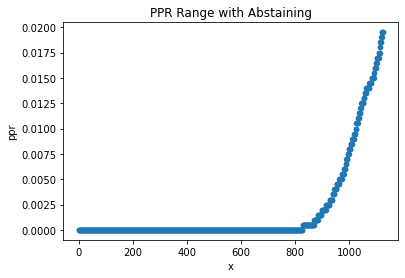

In [181]:
ppr_sort = ppr.sort_values(by = ['ppr'], ascending=True)
#x = np.linspace(0,(len(ppr_sort))-2, (len(ppr_sort)-1))
x = np.linspace(0,1156,1157)
x = x.astype(int)
x = pd.DataFrame(x, columns = ['x'])
ppr_sort = pd.concat([ppr_sort.reset_index(drop=True), x.reset_index(drop=True)], axis = 1)
ppr_sort
#ppr_sort = ppr_sort.reset_index(drop=True)
ppr_sort.plot( x = 'x' , y = 'ppr', kind = 'scatter')
plt.title('PPR Range with Abstaining')
plt.show()

Also, plot the proportion of test observations not abstained (i.e. the proportion of those predicted) for your abstain bagging model as a function of increasing  𝑃𝑃𝑅 .

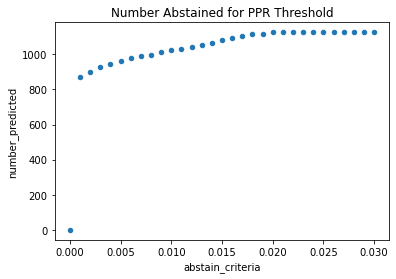

In [182]:
#ppr increase by .03 until we reach .3
#at each increiment, record the number of predictions above the threshold 
#add this to a df and plot 
segmented = np.linspace(0,.03,31)
below_threshold = []
for i in segmented:
    ppr_threshold = i
    count = 0
    #remove rows below threshold
    for index,row in ppr.iterrows():
        if row['ppr'] < ppr_threshold:
            count = 1 + count
    below_threshold.append(count)

below_threshold = pd.DataFrame(below_threshold, columns = ['number_predicted'])
segmented = pd.DataFrame(segmented, columns = ['abstain_criteria'])
abstain_bagging = pd.concat([segmented,below_threshold], axis = 1)

#plot
abstain_bagging.plot( x = 'abstain_criteria' , y = 'number_predicted', kind = 'scatter')
plt.title('Number Abstained for PPR Threshold')
plt.show()

**INTERPRETATION:**

The abstain model worked as expected, selecting lower probability guesses and removing them. Our model seemed fairly confident until it got to the .98% confident threshold, after which it begins to trail off and we lose approvimately 300 predictions from that point. This could be a good method for only guessing on items we are certain of and moving others to more rigerous inspection methods. 

<a id="part2"></a>

<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

# PART 2 [35 pts]: Kannada MNIST Kaggle competition

[Return to contents](#contents)


<a id="part2intro"></a>

## Problem Statement

[Return to contents](#contents)


ANNs can be prone to overfitting, where they learn specific patterns present in the training data, but the patterns do not generalize to new data.

There are several methods used to improve ANN generalization. 

One approach is to use an architecture just barely wide or deep enough to fit the data. The idea here is that smaller networks are less expressive and thus less able to overfit the data.

However, it is difficult to know a priori the correct size of the ANN, and it is computationally costly to hunt for the correct size. Given this, other methodologies are used to prevent overfitting and improve ANNs' generalizability. These methodologies, like other techniques that combat overfitting, fall under the umbrella term of "regularization".

In this problem, you are asked to regularize a network of a given architecture.

<a id="part2about"></a>

## The Kannada MNIST Dataset

[Return to contents](#contents)


![](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F3630446%2F1e01bcc28b5ccb7ad38a4ffefb13cde0%2Fwondu.png?generation=1603204077179447&alt=media)


For this problem, we will be working with a modified version of the [Kannada MNIST dataset](https://arxiv.org/pdf/1908.01242.pdf), which is a large database of handwritten digits in the indigenous language *Kannada*.

This dataset consists of 60,000 28x28 grayscale images of the ten digits, along with a test set of 10,000 images. 

For this homework, we will simplify the problem by only using the digits labeled `0` and `1` owing to the similarity of the two symbols, and we will use a total of 1,200 samples for training (this includes the data you will use for validation).

To understand the dataset better, we recommend this [article](https://towardsdatascience.com/a-new-handwritten-digits-dataset-in-ml-town-kannada-mnist-69df0f2d1456) by Vinay Prabhu, the curator of the dataset.

<a id="part2data"></a>

## Downloading the Data Files

[Return to contents](#contents)


**Please download the specific `kmnist_train.csv` and `kmnist_test.csv` data files available on [the "Data" tab of the CS109A HW7 Kaggle Competition website](https://www.kaggle.com/t/a361e7630e424da9abb12703c782a0c7). (DO NOT USE DATA FROM ANY OTHER SOURCE!)**

Here's a brief description of the data files:

- `kmnist_train.csv` is our training dataset and the last column contains our response class. The 784 other columns correspond to the pixel values of the 28x28 dimension image. Class 0 means a sample is the handwritten digit `0` and class 1 means a sample is the handwritten digit `1` in the Kannada written language. `kmnist_train.csv` has 1,200 samples.


- `kmnist_test.csv` has a structure similar to `kmnist_train.csv`, however the class label column is NOT included in with the test set. `kmnist_test.csv` has 2,000 samples. 


Kaggle leaderboard scores are accuracy scores calculated by Kaggle when you upload your predictions on this test set.

- `sample_submission.csv` is the format that kaggle will accept. The uploaded `.csv` must contain 2 columns. The first column must be named `id` and needs to contain the test observation index numbers for each prediction, the second must be named `category` and needs to contain your class predictions (i.e. `0` or `1`) for each corresponding test observation index location. 

<a id="part2kaggle"></a>

## CS109A Kaggle Competition

[Return to contents](#contents)

**ACCESS AND JOIN THE COMPETITION**:

**You need to create an account on Kaggle and [join the competition via this link](https://www.kaggle.com/t/a361e7630e424da9abb12703c782a0c7). This is a limited participation competition. Please DO NOT share this link.**

**For more information on the rules** governing this CS109A Kaggle competition, please see below and also review [the modelling restrictions DOS and DON'TS outlined in question 2.3](#q23).

**IMPORTANT NOTES ABOUT SCORING**:

- The **public leaderboard** on Kaggle displays your performance on only 50% of the test set.


- After the competition is complete, the **private leaderboard** will show your performance on the remaining 50% of the test set.


Only the **Top-25** competitors (as ranked on the hidden private leaderboard) will be eligible for full credit on [question 2.3](#q23) (out of **25 points**). Those in the **Top-50**, but not the **Top-25**, will be scored out of **24 points** on question 2.3. Those in the **Top-75**, but not **Top-50**, will be scored out of **23 points**. Those in the **Top-100**, but not **Top-75**, will be scored out of **22 points**. Those in the **Top-125**, but not **Top-100**, will be scored out of **21 points**. All remaining competitors will be scored out of **20 points only** for 2.3. (**NOTE:** additional points may still be deducted on question 2.3 for other non-score-related errors)

**BONUS:** An additional **5 bonus points** will be given to the **Top-3** competitors (as ranked on the hidden private leaderboard).

**ADDITIONAL COMPETITION RULES:**

- Multiple Kaggle submissions are permitted (with a maximum of 20 submissions per-participant per-day), **just note that you will need to choose, on Kaggle, the ONE single submission to use for final scoring prior to the final HW7 submission deadline**, and **your submitted notebook MUST contain the matching code and model that generated your ONE chosen submission.**


- **To repeat this point, the version of your final HW7 notebook submitted on Canvas MUST contain the same code and exact same model used to generate your ONE chosen Kaggle submission.** (TFs may rerun your notebook code to ensure comparable final leaderboard results.)


- **Please do not manually label your submissions.** In other words, the labels should only be the outcome of your model.


- **No external data are allowed, you MUST USE ONLY the KMNIST training and test data downloaded via the "Data" tab of [the CS109A competition page linked above](#part2data).**


- **Do not** create multiple accounts on Kaggle.


<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

<a id="part2questions"></a>

## <div class='exercise'>PART2 Questions</div>

[Return to contents](#contents)


<a id="q21"></a>

**[2.1:](#s21) Get and visualize the data**

- Download the train and test data from [the competition page](#part2data).
- We will utilize `kmnist_test.csv` in question 2.3.4 only. 
- Load the data and use the matplotlib function `imshow` to display a handwritten 0 and a handwritten 1 from the training set.

<a id="q22"></a>

**[2.2:](#s22) Overfit an ANN** 

Build and fit a fully-connected network (FCN) with the architecture given below using `tensorflow.keras` and assign it to a variable called `model_overfit`:

- Number of hidden layers: 3
- Nodes per hidden layer: 100, 100, 100
- Activation function: ReLU 
- Loss function: binary_crossentropy
- Output unit: Sigmoid 
- Optimizer: adam (use the defaults; no other tuning)
- Epochs: 1,000
- Batch size: 128
- Validation size: 0.3

![diagram](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F3630446%2F6a491ff8d4ff590dc8ded9a25461cd4b%2FScreenshot%202020-10-20%20at%209.42.36%20PM.png?generation=1603210420701577&alt=media) 
    
This ANN, when trained on the dataset, will overfit to the training set. Plot the training accuracy and validation accuracy (the x-axis should represent the number of epochs, and the y-axis should represent the accuracy). Explain how you can tell the model is overfitting. 

<a id="q23"></a>

**[2.3:](#s23) Regularize the overfit network**

Create an ANN that doesn't overfit and use it to [compete on Kaggle](#part2kaggle).

**DON'TS**

- **DO NOT change the architecture**. In other words, keep the same number of layers, same number of nodes, same activation function, and same loss function and output unit as was used in your question 2.2 overfit model. **No CNNs/RNNs/enhancements.**

- **DO NOT manually label your submissions.** In other words, the labels should only be the outcome of your model.

- **DO NOT use any external data.** Please use ONLY the specific KMNIST datasets provided to you (via the CS109A [data link above](#part2data)) for training your model and for generating your test predictions.

**DOS**

 - **YOU CAN change the** number of epochs (max 2000), batch size, optimizer, and of course, add elements that can help to regularize your model (e.g., dropout, L2 norm, etc.).
 - **YOU CAN also** do data augmentation using the provided training data. 

**IMPORTANT: YOU MUST** ensure that the version of the code and model in your final submitted notebook is the **EXACT SAME** code and model used to generate your Kaggle submission. TFs may run your submitted model to ensure comparable results. **Other Kaggle competition rules and scoring details [are listed here](#part2kaggle).**

- **[2.3.1:](#s231)** Build and train your regularized model (you MUST adhere to the "DOS" and "DON'TS" listed above), print your model summary, and print your final training and validation accuracy and loss.


- **[2.3.2:](#s232)** Plot your model's training accuracy and validation accuracy as a function of epochs.


- **[2.3.3:](#s233)** In several sentences, describe the approach you have taken to improve the performance of your regularized model in 2.3.1 and any observations you might have regarding your training and Kaggle results.


- **[2.3.4:](#s234)** Generate your test-set class predictions using your regularized model. Save those predictions to a `.csv` formatted file. Submit that `.csv` file [to the CS109A Kaggle Competition](#part2kaggle) for leaderboard scoring. **IMPORTANT:** For Kaggle to accept and score your submitted `.csv` file, it MUST contain 2 columns. The first column must be named `"id"` and needs to contain the test observation index numbers corresponding to each of your 2,000 predictions, the second must be named `"category"` and needs to contain your class predictions (i.e. `0` or `1`) for each corresponding test observation index location. 


- **[2.3.5:](#s235)** **Specify your Kaggle name that you have used on the leaderboard**. We CAN NOT give you credit without this.

<a id="part2solutions"></a>

## PART 2 Solutions

[Return to contents](#contents)


<a id="s21"></a>

<div class='exercise-r'>

**[2.1:](#q21) Get and visualize the data**

- Download the train and test data from [the competition page](#part2data).
- We will utilize `kmnist_test.csv` in question 2.3.4 only. 
- Load the data and use the matplotlib function `imshow` to display a handwritten 0 and a handwritten 1 from the training set.


</div>

In [183]:
# your code here
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.layers import Dropout


kmnist_train = pd.read_csv('kmnist_train.csv')


kmnist_test = pd.read_csv('kmnist_test.csv')

X_train = kmnist_train.drop(['output'], axis = 1)
y_train = kmnist_train['output']
y_train = pd.DataFrame(y_train)
X_train

X_test = kmnist_test


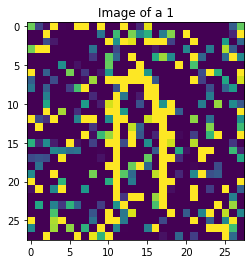

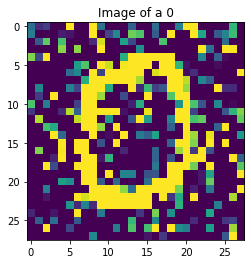

In [184]:
#Show a 1 value
one_row = X_train.loc[0]
one_row = one_row.values.reshape(-1,28,28,1)
plt.imshow(one_row [0][:,:,0])
plt.title("Image of a 1") 
plt.show()

#Show a 0 value
zero_row = X_train.loc[2]
zero_row= zero_row.values.reshape(-1,28,28,1)
plt.imshow(zero_row [0][:,:,0])
plt.title("Image of a 0")
plt.show()


<a id="s22"></a>

<div class='exercise-r'>

**[2.2:](#q22) Overfit an ANN** 

Build and fit a fully-connected network (FCN) with the architecture given below using `tensorflow.keras` and assign it to a variable called `model_overfit`:

- Number of hidden layers: 3
- Nodes per hidden layer: 100, 100, 100
- Activation function: ReLU 
- Loss function: binary_crossentropy
- Output unit: Sigmoid 
- Optimizer: adam (use the defaults; no other tuning)
- Epochs: 1,000
- Batch size: 128
- Validation size: 0.3

![diagram](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F3630446%2F6a491ff8d4ff590dc8ded9a25461cd4b%2FScreenshot%202020-10-20%20at%209.42.36%20PM.png?generation=1603210420701577&alt=media) 
    
This ANN, when trained on the dataset, will overfit to the training set. Plot the training accuracy and validation accuracy (the x-axis should represent the number of epochs, and the y-axis should represent the accuracy). Explain how you can tell the model is overfitting.
    
</div>

In [185]:
%%time
# your code here
n_input = len(X_train.columns)

model_overfit = models.Sequential(name='Overfit_model')

# First hidden layer 
model_overfit.add(layers.Dense(100, activation='relu', name = 'hidden1', input_shape=(n_input,)))
#add second hidden layer
model_overfit.add(layers.Dense(100, activation='relu', name = 'hidden2'))
#add third hidden layer
model_overfit.add(layers.Dense(100, activation='relu', name = 'hidden3'))

#add output layer
model_overfit.add(layers.Dense(1, activation='sigmoid', name='output'))


# compile it and run it
optimizer = optimizers.Adam(lr=0.001) 

model_overfit.compile(loss='binary_crossentropy', optimizer=optimizer, metrics = ['accuracy']) 

model_overfit.summary()

history = model_overfit.fit(X_train, y_train, batch_size= 128, verbose = 0, epochs=100,validation_split=.3) 

train_accuracy = model_overfit.evaluate(X_train,y_train)[1]
#test_accuracy = model_overfit.evaluate(X_test,y_test)[1]
print(f'The training set accuracy for the model is {train_accuracy}\\n The test set accuracy for the model is {test_accuracy}')

Model: "Overfit_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 100)               78500     
_________________________________________________________________
hidden2 (Dense)              (None, 100)               10100     
_________________________________________________________________
hidden3 (Dense)              (None, 100)               10100     
_________________________________________________________________
output (Dense)               (None, 1)                 101       
Total params: 98,801
Trainable params: 98,801
Non-trainable params: 0
_________________________________________________________________
38/38 [==============================] - 0s 832us/step - loss: 0.0965 - accuracy: 0.9775
The training set accuracy for the model is 0.9775000214576721\n The test set accuracy for the model is 0.6408203840255737
CPU times: user 6.19 s, sys: 816 ms,

Text(0.5, 0.98, 'Overfit Model')

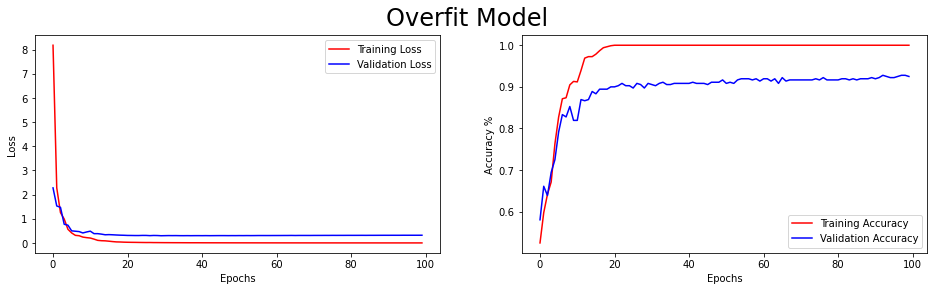

In [186]:
# plot train and val acc as a function of epochs
# your code here
fig, ax = plt.subplots(1,2,figsize = (16,4))

ax[0].plot(history.history['loss'],'r',label = 'Training Loss')
ax[0].plot(history.history['val_loss'],'b',label = 'Validation Loss')
ax[1].plot(history.history['accuracy'],'r',label = 'Training Accuracy')
ax[1].plot(history.history['val_accuracy'],'b',label = 'Validation Accuracy')
ax[0].legend()
ax[1].legend()
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs');
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Accuracy %');
fig.suptitle('Overfit Model', fontsize = 24)

**INTERPRETATION:**

*Your answer here*


<a id="s23"></a>

<div class='exercise-r'>

**[2.3:](#q23) Regularize the overfit network**

Create an ANN that doesn't overfit and use it to [compete on Kaggle](#part2kaggle).

**DON'TS**

- **DO NOT change the architecture**. In other words, keep the same number of layers, same number of nodes, same activation function, and same loss function and output unit as was used in your question 2.2 overfit model. **No CNNs/RNNs/enhancements.**

- **DO NOT manually label your submissions.** In other words, the labels should only be the outcome of your model.

- **DO NOT use any external data.** Please use ONLY the specific KMNIST datasets provided to you (via the CS109A [data link above](#part2data)) for training your model and for generating your test predictions.

**DOS**

 - **YOU CAN change the** number of epochs (max 2000), batch size, optimizer, and of course, add elements that can help to regularize your model (e.g., dropout, L2 norm, etc.).
 - **YOU CAN also** do data augmentation using the provided training data. 

**IMPORTANT: YOU MUST** ensure that the version of the code and model in your final submitted notebook is the **EXACT SAME** code and model used to generate your Kaggle submission. TFs may run your submitted model to ensure comparable results. **Other Kaggle competition rules and scoring details [are listed here](#part2kaggle).**

<a id="s231"></a>

**[2.3.1:](#q23)** Build and train your regularized model (you MUST adhere to the "DOS" and "DON'TS" listed above), print your model summary, and print your final training and validation accuracy and loss.
    
</div>

In [187]:
%%time
from keras import regularizers
from keras.layers import GaussianNoise
from keras.layers import BatchNormalization

n_input = len(X_train.columns)

model_fit = models.Sequential(name='fit_model')

#model_fit.add(tf.keras.layers.Flatten())

model_fit.add(layers.Dense(100, activation='relu', name = 'hidden1', input_shape=(n_input,)))
model_fit.add(Dropout(0.1))
model_fit.add(layers.Dense(100, activation='relu', name = 'hidden2'))
model_fit.add(Dropout(0.1))
model_fit.add(layers.Dense(100,activation='relu', name = 'hidden3'))
model_fit.add(Dropout(0.1))
#add output layer
model_fit.add(layers.Dense(1, activation='sigmoid', name='output'))

# compile it and run it
optimizer = optimizers.Adam(lr=0.001) 

model_fit.compile(loss='binary_crossentropy', optimizer=optimizer, metrics = ['accuracy']) 

model_fit.summary()

history = model_fit.fit(X_train, y_train, batch_size= 128, verbose = 0, epochs=1000,validation_split=.3) 

Model: "fit_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 100)               78500     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
hidden2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
hidden3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
output (Dense)               (None, 1)                 10

In [188]:
y_pred = model_fit.predict(X_test)
y_pred = pd.DataFrame(y_pred)

pred = []
for index,row in y_pred.iterrows():
    pred_row = row[0]
    if pred_row >= .5:
        pred.append(1)
    else:
        pred.append(0)
        
y_pred[0] = pred

train_accuracy = model_fit.evaluate(X_train,y_train)[1]
print(f'The training set accuracy for the model is {train_accuracy}\\n The test set accuracy for the model is {test_accuracy}')

38/38 [==============================] - 0s 763us/step - loss: 0.1320 - accuracy: 0.9767
The training set accuracy for the model is 0.9766666889190674\n The test set accuracy for the model is 0.6408203840255737


<a id="s232"></a>

<div class='exercise-r'>

**[2.3.2:](#q23)** Plot your model's training accuracy and validation accuracy as a function of epochs.

</div>

Text(0.5, 0.98, 'Best Fit Model')

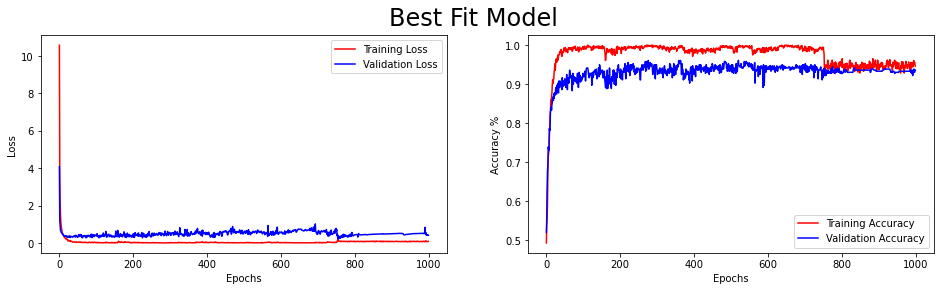

In [189]:
# plot train and val acc as a function of epochs
fig, ax = plt.subplots(1,2,figsize = (16,4))

ax[0].plot(history.history['loss'],'r',label = 'Training Loss')
ax[0].plot(history.history['val_loss'],'b',label = 'Validation Loss')
ax[1].plot(history.history['accuracy'],'r',label = 'Training Accuracy')
ax[1].plot(history.history['val_accuracy'],'b',label = 'Validation Accuracy')
ax[0].legend()
ax[1].legend()
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs');
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Accuracy %');
fig.suptitle('Best Fit Model', fontsize = 24)

<a id="s233"></a>

<div class='exercise-r'>

**[2.3.3:](#q23)** In several sentences, describe the approach you have taken to improve the performance of your regularized model in 2.3.1 and any observations you might have regarding your training and Kaggle results.

</div>

**APPROACH AND OBSERVATIONS:**

I tried a number of approaches and was having very little success in getting something that worked well. The dropout layers seemed to be the most helpful addition I did. In my process I tried adding L2_norm, GaussianNoise, and BatchNormalization layers in various combinations, but I couldn't get anything to work better than the dropout layers which was really frustrating. I spend around 2 hours trying different strategies to little avail. This homework was EXTREMELY long, especially considering we had our project milestone due the week before.

<a id="s234"></a>

<div class='exercise-r'>

**[2.3.4:](#q23)** Generate your test-set class predictions using your regularized model. Save those predictions to a `.csv` formatted file. Submit that `.csv` file [to the CS109A Kaggle Competition](#part2kaggle) for leaderboard scoring. **IMPORTANT:** For Kaggle to accept and score your submitted `.csv` file, it MUST contain 2 columns. The first column must be named `"id"` and needs to contain the test observation index numbers corresponding to each of your 2,000 predictions, the second must be named `"category"` and needs to contain your class predictions (i.e. `0` or `1`) for each corresponding test observation index location.

</div>

In [190]:
# your code here
y_pred.to_csv('y_pred5.csv')

<a id="s235"></a>

<div class='exercise-r'>

**[2.3.5:](#q23)** **Specify your Kaggle name that you have used on the leaderboard**. We CAN NOT give you credit without this.

</div>

**YOUR KAGGLE LEADERBOARD NAME:**

Leaderboard Name :Steven Morse

[Return to contents](#contents)